## **Section 0** - ESSENTIALS: Install and load libraries
- Even though we clone our own github repo to access our developed modules, we still to install the library dependencies.

In [2]:
!pip install rarfile
!pip install gitpython
!pip install ta
!pip install hurst
!pip install catboost
# pip install bayes_opt

### Clone/Reclone the repo to pull in the latest updates.
- When you need to do this, uncomment the below code and run.

# Introduction:
- This notebook pulls in minutely data from Github repo. **Class TickerData** and its functions help to do that.
https://github.com/laughingbud/capstone/tree/main/Data
- Exploratory research is then conducted on the data using the **class Exploratory** and its functions
- Technical indicators are defined and built in the **class Strategy**. The function calculate_analytics takes the return series of any strategy and returns sharpe ratio, annual return, vol,etc type of analytics.
## Work so far:
Note: Only tested 'Bank Nifty' ticker but can be expanded later
- Till now we explored mean reversion strategy using Bollinger bands strategy and did robustness testing by varying look back window, band size and implementation lag(shift signal by 2 or more).
- We also explored seasonality strategy by looking at different seasonality windows where autocorrelations are statistically signficant.
## Next step:
- Develop strategies (mean reversion or trend) using other technical indicators. We are aiming to have around 12-15 technical indicator strategies at the minimum.
- Develop a cross sectional strategy (elaborated on the email to Prof.Rito) with a bigger universe.
- If still have time, explore ML based strategy using all these technical indicators to forecast return minutes (5mins,10,15,30, 1hour, 4hour,upto daily) ahead.


In [3]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib

In [4]:
repo_url = 'https://github.com/laughingbud/capstone.git'
repo_name = re.search(r'/([^/]+)\.git$', repo_url).group(1)

if os.path.exists(f'/content/{repo_name}'):
    %cd /content/capstone
    !git pull
    import importlib
    import Exploratory
    importlib.reload(Exploratory)
    import Strategy
    importlib.reload(Strategy)
    import TickerData
    importlib.reload(TickerData)
    # !rm -rf '/content/capstone'
    # %cd content
else:
    %cd /content/
    !git clone https://github.com/laughingbud/capstone.git

/content/capstone
Already up to date.


# 1. Classes
-  TickerData - mainly for data import from YF and storing in git repo
-  Exploratory - For exploring interesting patterns and characteristics about data
-  Strategy - For strategy and feature creation

In [5]:
%cd /content/capstone
from TickerData import TickerData
from Exploratory import Exploratory
from Strategy import Strategy

/content/capstone


### Import data

In [6]:
# Initialize classes for later use
exp = Exploratory()
st = Strategy()

In [7]:
repo_url = 'https://github.com/laughingbud/capstone'
td = TickerData(repo_url=repo_url)

In [8]:
minutely_tickers,ticker_dict = td.get_minutely_tickers()
# ticker_dict

15817 CSV files found: ['/content/capstone/Data/Futures IEOD-April 2023/JINDALSTEL_F3.csv', '/content/capstone/Data/Futures IEOD-April 2023/GLENMARK_F2.csv', '/content/capstone/Data/Futures IEOD-April 2023/MRF_F2.csv', '/content/capstone/Data/Futures IEOD-April 2023/TECHM_F2.csv', '/content/capstone/Data/Futures IEOD-April 2023/EICHERMOT_F1.csv', '/content/capstone/Data/Futures IEOD-April 2023/ZEEL_F2.csv', '/content/capstone/Data/Futures IEOD-April 2023/BIOCON_F3.csv', '/content/capstone/Data/Futures IEOD-April 2023/SUNPHARMA_F1.csv', '/content/capstone/Data/Futures IEOD-April 2023/IDFCFIRSTB_F3.csv', '/content/capstone/Data/Futures IEOD-April 2023/INTELLECT_F2.csv', '/content/capstone/Data/Futures IEOD-April 2023/IBULHSGFIN_F1.csv', '/content/capstone/Data/Futures IEOD-April 2023/IGL_F1.csv', '/content/capstone/Data/Futures IEOD-April 2023/CIPLA_F2.csv', '/content/capstone/Data/Futures IEOD-April 2023/INDIACEM_F1.csv', '/content/capstone/Data/Futures IEOD-April 2023/HAVELLS_F2.csv', 

In [9]:
bank_nifty_f1 = td.load_minutely_data(ticker='BANKNIFTY',filter='F1')

Reading CSV file: /content/capstone/Data/Futures IEOD-April 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-September 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-June 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-October 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-March 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-April 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-March 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-May 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-January 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-June 2023/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-August 2022/BANKNIFTY_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-November 2023/BANKNIFTY_F1.csv
Reading 

In [10]:
bank_nifty_f1.head()

ticker      open      high       low     close  \
datetime                                                                    
2022-01-03 09:15:00  BANKNIFTY_F1  36621.00  36621.00  35708.05  35811.85   
2022-01-03 09:16:00  BANKNIFTY_F1  35813.95  35825.75  35798.70  35798.70   
2022-01-03 09:17:00  BANKNIFTY_F1  35796.55  35796.90  35757.40  35782.60   
2022-01-03 09:18:00  BANKNIFTY_F1  35782.60  35834.25  35782.60  35834.25   
2022-01-03 09:19:00  BANKNIFTY_F1  35830.50  35839.65  35823.40  35835.00   

                     volume       OI    return  
datetime                                        
2022-01-03 09:15:00   82603  2347925  0.000000  
2022-01-03 09:16:00   38900  2347925 -0.000367  
2022-01-03 09:17:00   28775  2368975 -0.000450  
2022-01-03 09:18:00   28900  2368975  0.001442  
2022-01-03 09:19:00   28275  2368975  0.000021

In [11]:
data = bank_nifty_f1.copy()
print(f'Shape of data is {data.shape}')
data_ins = bank_nifty_f1.iloc[:int(bank_nifty_f1.shape[0]*0.8),:].copy()
print(f'Shape of in-sample data is {data_ins.shape}')
data_oos = bank_nifty_f1.iloc[int(bank_nifty_f1.shape[0]*0.8):,:].copy()
print(f'Shape of out-sample data is {data_oos.shape}')

Shape of data is (184603, 8)
Shape of in-sample data is (147682, 8)
Shape of out-sample data is (36921, 8)


In [12]:
minutely_tickers # Show all tickers

['AARTIIND',
 'ABB',
 'ABBOTINDIA',
 'ABCAPITAL',
 'ABFRL',
 'ACC',
 'ADANIENT',
 'ADANIPORTS',
 'ALKEM',
 'AMBUJACEM',
 'APOLLOHOSP',
 'APOLLOTYRE',
 'ASHOKLEY',
 'ASIANPAINT',
 'ASTRAL',
 'ATUL',
 'AUBANK',
 'AUROPHARMA',
 'AXISBANK',
 'BAJAJFINSV',
 'BAJFINANCE',
 'BALKRISIND',
 'BALRAMCHIN',
 'BANDHANBNK',
 'BANKBARODA',
 'BANKNIFTY',
 'BATAINDIA',
 'BEL',
 'BERGEPAINT',
 'BHARATFORG',
 'BHARTIARTL',
 'BHEL',
 'BIOCON',
 'BOSCHLTD',
 'BPCL',
 'BRITANNIA',
 'BSOFT',
 'CANBK',
 'CANFINHOME',
 'CHAMBLFERT',
 'CHOLAFIN',
 'CIPLA',
 'COALINDIA',
 'COFORGE',
 'COLPAL',
 'CONCOR',
 'COROMANDEL',
 'CROMPTON',
 'CUB',
 'CUMMINSIND',
 'DABUR',
 'DALBHARAT',
 'DEEPAKNTR',
 'DELTACORP',
 'DIVISLAB',
 'DIXON',
 'DLF',
 'DRREDDY',
 'EICHERMOT',
 'ESCORTS',
 'EXIDEIND',
 'FEDERALBNK',
 'FINNIFTY',
 'GAIL',
 'GLENMARK',
 'GMRINFRA',
 'GNFC',
 'GODREJCP',
 'GODREJPROP',
 'GRANULES',
 'GRASIM',
 'GUJGASLTD',
 'HAL',
 'HAVELLS',
 'HCLTECH',
 'HDFC',
 'HDFCAMC',
 'HDFCBANK',
 'HDFCLIFE',
 'HEROMOTOCO'

In [13]:
# index_tickers
index_tickers = [x for x in minutely_tickers if 'NIFTY' in x]
print('Index futures tickers:',index_tickers)

Index futures tickers: ['BANKNIFTY', 'FINNIFTY', 'MIDCPNIFTY', 'NIFTY']


In [14]:
equity_tickers = [x for x in minutely_tickers if 'NIFTY' not in x]
print('Equity futures tickers:',equity_tickers)

Equity futures tickers: ['AARTIIND', 'ABB', 'ABBOTINDIA', 'ABCAPITAL', 'ABFRL', 'ACC', 'ADANIENT', 'ADANIPORTS', 'ALKEM', 'AMBUJACEM', 'APOLLOHOSP', 'APOLLOTYRE', 'ASHOKLEY', 'ASIANPAINT', 'ASTRAL', 'ATUL', 'AUBANK', 'AUROPHARMA', 'AXISBANK', 'BAJAJFINSV', 'BAJFINANCE', 'BALKRISIND', 'BALRAMCHIN', 'BANDHANBNK', 'BANKBARODA', 'BATAINDIA', 'BEL', 'BERGEPAINT', 'BHARATFORG', 'BHARTIARTL', 'BHEL', 'BIOCON', 'BOSCHLTD', 'BPCL', 'BRITANNIA', 'BSOFT', 'CANBK', 'CANFINHOME', 'CHAMBLFERT', 'CHOLAFIN', 'CIPLA', 'COALINDIA', 'COFORGE', 'COLPAL', 'CONCOR', 'COROMANDEL', 'CROMPTON', 'CUB', 'CUMMINSIND', 'DABUR', 'DALBHARAT', 'DEEPAKNTR', 'DELTACORP', 'DIVISLAB', 'DIXON', 'DLF', 'DRREDDY', 'EICHERMOT', 'ESCORTS', 'EXIDEIND', 'FEDERALBNK', 'GAIL', 'GLENMARK', 'GMRINFRA', 'GNFC', 'GODREJCP', 'GODREJPROP', 'GRANULES', 'GRASIM', 'GUJGASLTD', 'HAL', 'HAVELLS', 'HCLTECH', 'HDFC', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDCOPPER', 'HINDPETRO', 'HINDUNILVR', 'IBULHSGFIN', 'ICICIBANK'

In [15]:
print(f'Total number of futures tickers: {len(minutely_tickers)}')
print(f'Total number of index futures tickers: {len(index_tickers)}')
print(f'Total number of equity futures tickers: {len(equity_tickers)}')

Total number of futures tickers: 186
Total number of index futures tickers: 4
Total number of equity futures tickers: 182


In [14]:
data_summary = pd.DataFrame(ticker_dict).T
data_summary.index.name = 'Tickers'
data_summary.tail()

files  \
Tickers                                                        
VEDL       [/content/capstone/Data/Futures IEOD-April 202...   
VOLTAS     [/content/capstone/Data/Futures IEOD-April 202...   
WIPRO      [/content/capstone/Data/Futures IEOD-April 202...   
ZEEL       [/content/capstone/Data/Futures IEOD-April 202...   
ZYDUSLIFE  [/content/capstone/Data/Futures IEOD-April 202...   

                                                      months n_months n_files  
Tickers                                                                        
VEDL       [Futures IEOD-July 2023, Futures IEOD-April 20...       24      72  
VOLTAS     [Futures IEOD-July 2023, Futures IEOD-April 20...       24      72  
WIPRO      [Futures IEOD-July 2023, Futures IEOD-April 20...       24      72  
ZEEL       [Futures IEOD-July 2023, Futures IEOD-April 20...       24      72  
ZYDUSLIFE  [Futures IEOD-July 2023, Futures IEOD-April 20...       22      66

In [ ]:
# ticker_dict['INDUSTOWER']['files']

In [ ]:
# data_summary.loc['INDUSTOWER']['files']

In [ ]:
# data_summary['n_months'].sort_values().head(50).plot(kind='bar',figsize=(20,5),
#                                             title='Number of months of data')

#### Of the 186 unique tickers, almost all of them have 24 months of data, except seven (left-most in the above chart) firms - PVRINOX, LTIM, SRIRAMFIN,RAIN, INTELLECT, MOTHERSON, ZYDUSLIFE.

In [ ]:
# data_summary['n_files'].sort_values().head(50).plot(kind='bar',figsize=(20,5),
#                                                     title='Number of files for each ticker')

In [ ]:
# ticker_dict['NIFTY']

In [ ]:
# nifty_f1 = td.load_minutely_data(ticker='NIFTY',filter='F1') ,infer_datetime_format=True

In [ ]:
# midcp_nifty_f1 = td.load_minutely_data(ticker='MIDCPNIFTY',filter='F1')

In [ ]:
# bank_nifty_f2 = td.load_minutely_data(ticker='BANKNIFTY',filter='F2')

In [ ]:
# bank_nifty_f1.head(2)

In [ ]:
# bank_nifty_f1.tail(2)

In [ ]:
bank_nifty_f1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184603 entries, 2022-01-03 09:15:00 to 2023-12-29 15:30:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  184603 non-null  object 
 1   open    184603 non-null  float64
 2   high    184603 non-null  float64
 3   low     184603 non-null  float64
 4   close   184603 non-null  float64
 5   volume  184603 non-null  int64  
 6   o/i     184603 non-null  int64  
 7   return  184603 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 12.7+ MB


In [ ]:
bank_nifty_f1.describe()

open           high           low          close  \
count  184603.000000  184603.000000  184603.00000  184603.000000   
mean    40837.446985   40848.877055   40826.08283   40837.489332   
std      3814.313773    3812.615708    3815.91624    3814.308178   
min     32261.000000   32300.750000   32251.35000   32253.050000   
25%     37906.675000   37920.850000   37891.62500   37906.025000   
50%     41499.700000   41510.000000   41488.05000   41499.000000   
75%     43954.898400   43963.224600   43945.77540   43954.898400   
max     48751.000000   48805.000000   48716.25000   48758.449200   

              volume           o/i         return  
count  184603.000000  1.846030e+05  184603.000000  
mean     9226.980986  2.214122e+06       0.000002  
std     11538.802848  4.908666e+05       0.000569  
min        15.000000  0.000000e+00      -0.028878  
25%      3000.000000  1.993005e+06      -0.000212  
50%      5715.000000  2.265375e+06       0.000000  
75%     11125.000000  2.496375e+06       0.000213  
max    427401.000000  3.866500e+06       0.027743

In [ ]:
bank_nifty_f1.isna().sum().rename('NaNs').to_frame().T

ticker  open  high  low  close  volume  o/i  return
NaNs       0     0     0    0      0       0    0       0

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(18,5))
# bank_nifty_f1['volume'].plot(title='Bank Nifty F1 - Volume',
#                              label='F1',ax=ax[0])
# # plt.show()
# bank_nifty_f2['volume'].plot(title='Bank Nifty F2 - Volume',
#                              label='F2',ax=ax[1])
# plt.tight_layout()
# plt.show()

In [ ]:
# bank_nifty_f1['o/i'].plot(figsize=(12,5),title='Bank Nifty - Open-Interest')
# bank_nifty_f2['o/i'].plot(figsize=(12,5),title='Bank Nifty - Open-Interest')
# plt.legend(['F1','F2'])

In [ ]:
# bank_nifty_f1['return'] = np.log(bank_nifty_f1['close'] / bank_nifty_f1['close'].shift(1))

# 2. Exploratory research

In [ ]:
bank_nifty_f1.columns

Index(['ticker', 'open', 'high', 'low', 'close', 'volume', 'OI', 'return'], dtype='object')

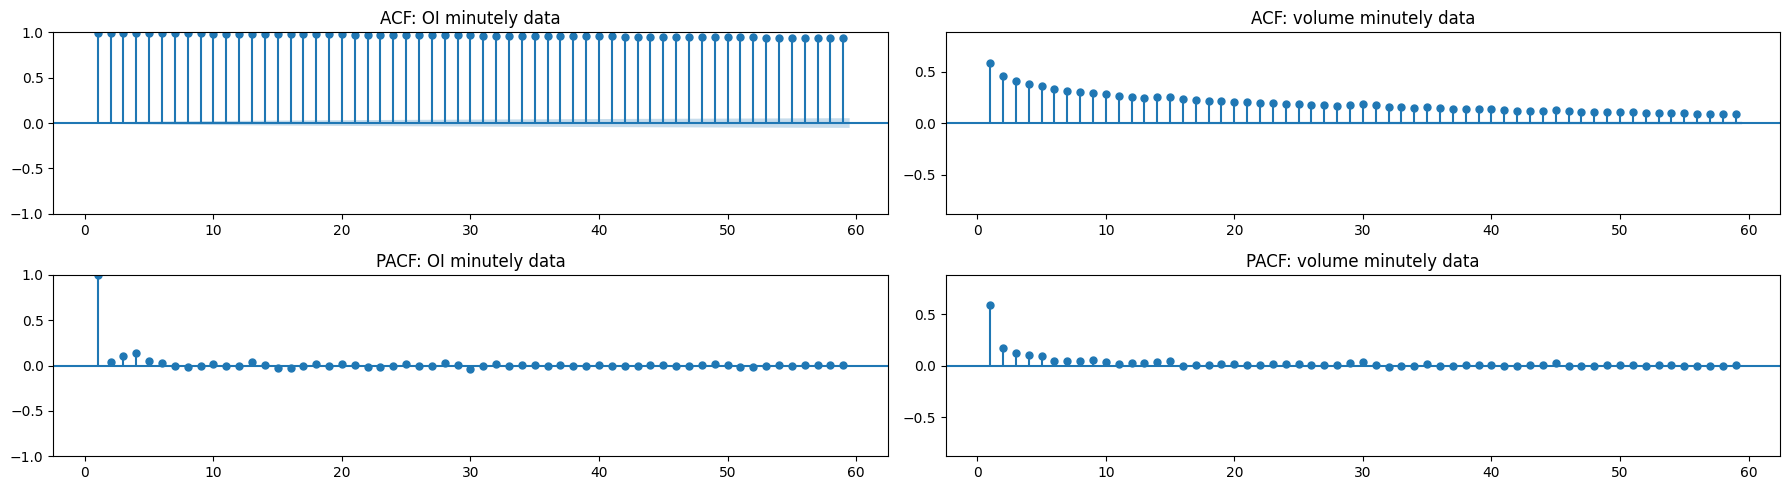

In [ ]:
exp.plot_autocorrelations(data_ins[['OI','volume']],maxlags=60,label='minutely data')

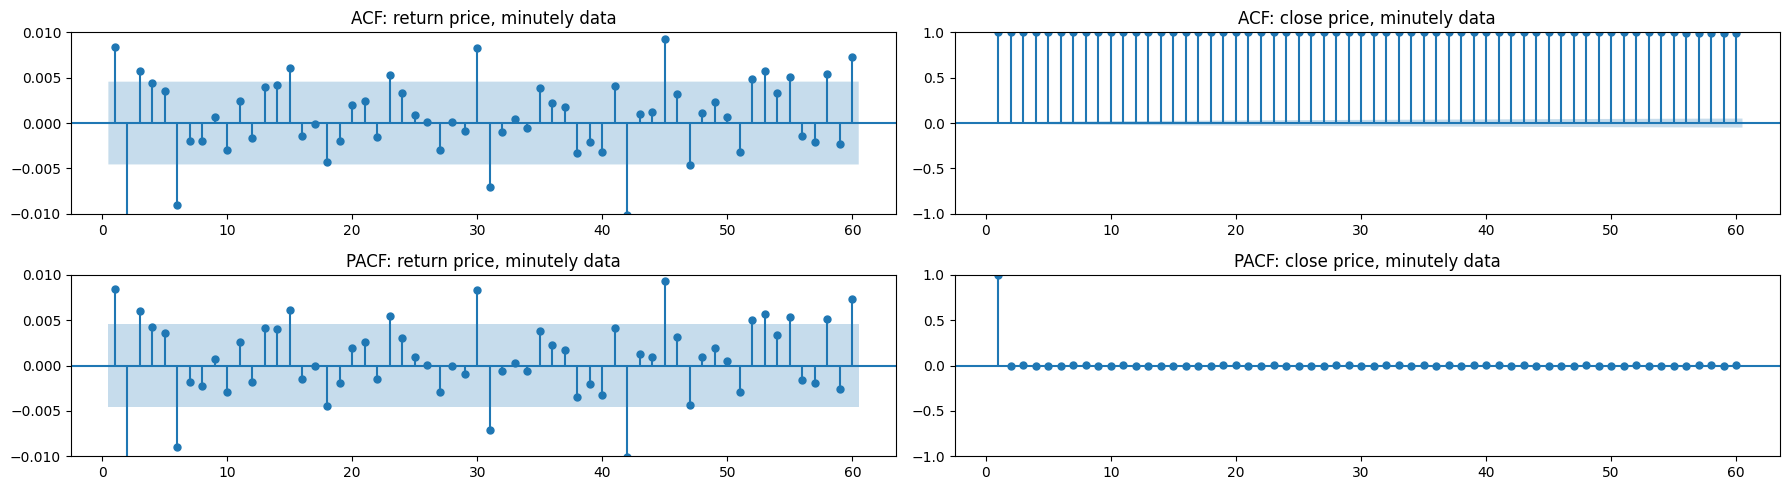

In [ ]:
exp.plot_autocorrelations(bank_nifty_f1[['return','close']].dropna(),maxlags=61,label='price, minutely data')

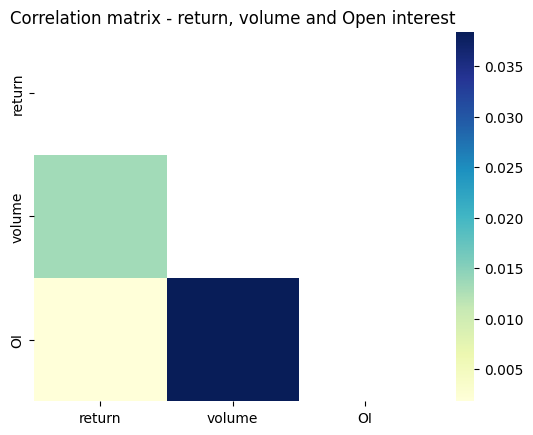

In [ ]:
exp.plot_corr(data_ins[['return','volume','OI']],
              title='Correlation matrix - return, volume and Open interest')
plt.show()

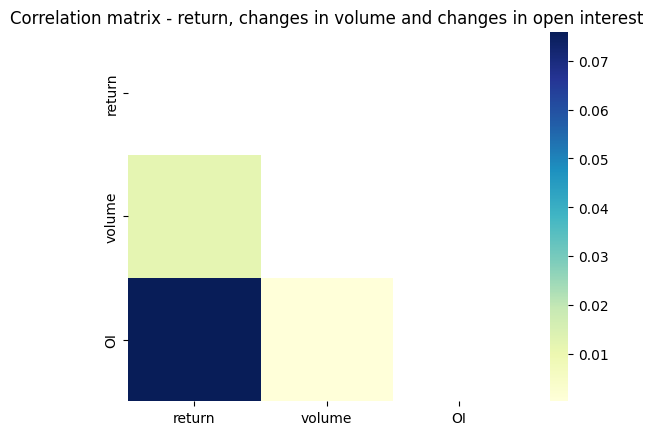

In [ ]:
exp.plot_corr(pd.concat([bank_nifty_f1[['return']],
                         bank_nifty_f1[['volume','OI']].diff()],axis=1),
              title='Correlation matrix - return, changes in volume and changes in open interest')
plt.show()

# 3. Strategy development

## 3.1 Bollinger band - Mean reversion and trend

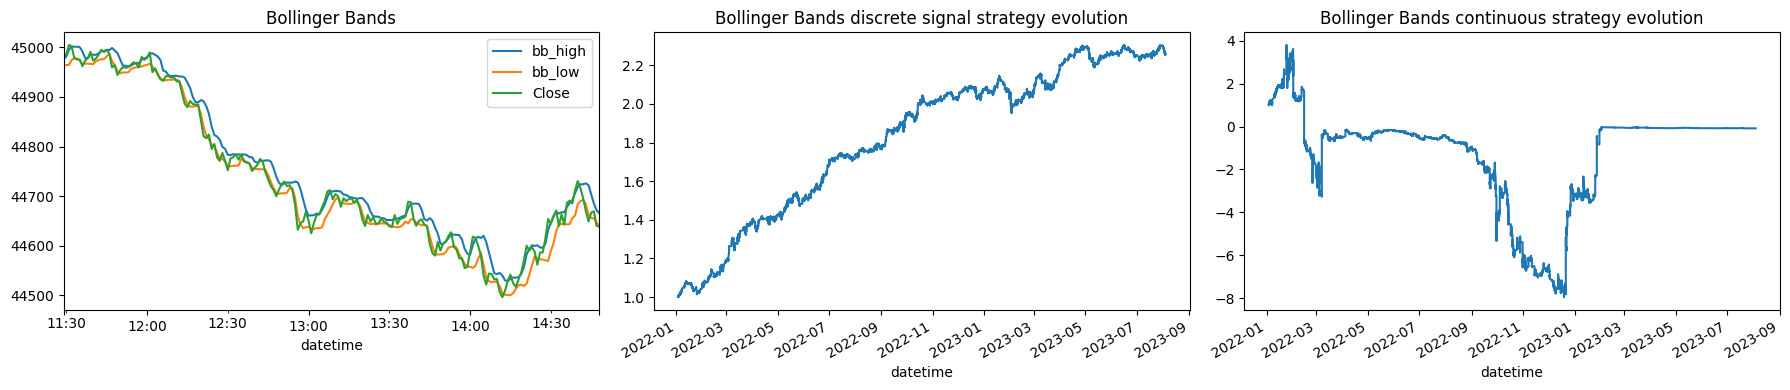

In [ ]:
bb_high,bb_low,bb_sig_discrete,bb_sig_cont = st.bb_signal(data_ins.copy(),
                                                          window=5,window_dev=1)
fig,ax = plt.subplots(1,3,figsize=(18,4))

pd.DataFrame({'bb_high':bb_high,
              'bb_low':bb_low,
              'Close':data_ins['close'],
              },index=data_ins.index).tail(200).plot(ax=ax[0],title='Bollinger Bands')
lag=2
(1+pd.Series(bb_sig_discrete,index=data_ins.index).shift(lag)*data_ins['return']).cumprod().plot(ax=ax[1],title='Bollinger Bands discrete signal strategy evolution')

(1+pd.Series(bb_sig_cont,index=data_ins.index).shift(lag)*data_ins['return']).cumprod().plot(ax=ax[2],title='Bollinger Bands continuous strategy evolution')

plt.tight_layout()
plt.show()

In [ ]:
bb_sig_discrete

<Axes: title={'center': 'Bollinger Bands discrete signal evolution'}, xlabel='datetime'>

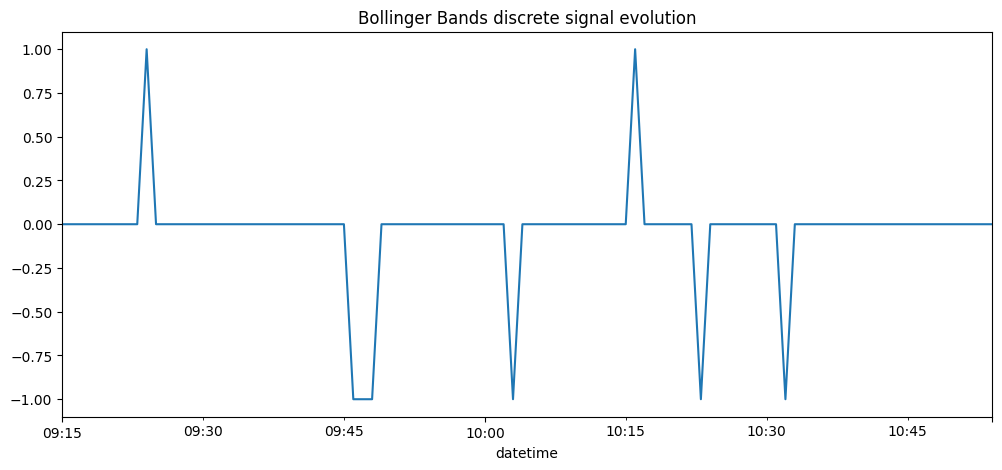

In [ ]:
pd.Series(bb_sig_discrete,index=bank_nifty_f1.index).head(100).plot(figsize=(12,5),title='Bollinger Bands discrete signal evolution')
# pd.Series(bb_sig_cont,index=bank_nifty_f1.index).head(100).plot()

### Robustness check - Bollinger bands strategy

In [ ]:
# _,_,bb_signal = st.bb_signal(data,window=15,
#                                      window_dev=2)
# pd.Series(bb_signal,index=data.index).shift(1).plot(figsize=(12,5),title='Bollinger Bands signal evolution')
# # (1+pd.Series(bb_signal,index=data.index).shift(1)*data['return']).cumprod().head(200).plot()

The below functions help to test robustness by varying parameters and plot results.

In [ ]:
def test_robustness(data,indicator,multiplier,lookback_window,band_tol,lags):
    if multiplier not in (1, -1):
        raise ValueError("Multiplier must be either 1 or -1")
    results = []
    ts = {'signal': {}, 'strategy_returns': {}, 'cumulative_returns': {}}
    count_bands = len(np.arange(band_tolerance['start'],band_tolerance['end']+band_tolerance['step'],
                    band_tolerance['step']))
    fig,ax = plt.subplots(1,count_bands,figsize=(18,4))
    for i,band_tol in enumerate(np.arange(band_tol['start'],band_tol['end']+band_tol['step'],
                          band_tol['step'])):
        legend = []
        band_tol = band_tol.round(1) if isinstance(band_tol, float) else band_tol
        # print(i)
        for window in range(lookback_window['start'],
                            lookback_window['end']+lookback_window['step'],
                            lookback_window['step']):
            if indicator == 'BollingerBand':
                _,_,signal,_ = st.bb_signal(data,window=window,
                                            window_dev=band_tol)
            elif indicator == 'ATR':
                atr, ub, lb, atr_z, signal = st.atr_signal(data,window=window,
                                                           ts_hl=120,
                                                           smoothing_hl=20,
                                                           threshold=band_tol)
            else:
                raise ValueError("Indicator must be either 'BollingerBand' or 'ATR'")

            (1+pd.Series(signal,index=data[-len(signal):].index).shift(1)*data_ins['return'][-len(signal):]).cumprod().plot(
                title=f'{indicator} strategy,band_tol={band_tol},no lag',ax=ax[i])
            legend.append(f'window={window}')
            for lag in range(lags['start'],lags['end']+lags['step'],lags['step']):
                data['signal'] = pd.Series(signal,
                                           index=data[-len(signal):].index
                                           ).shift(lag).fillna(0)
                strategy_returns = multiplier * data['signal'] * data['return']
                # Identify the start and end of holding periods
                data['holding'] = pd.Series(
                    signal,index=data[-len(signal):].index
                    ).shift(lag).diff().fillna(0).abs()
                data['holding'] = data['holding'].cumsum()
                # Calculate the duration of each holding period
                holding_periods = data[data['signal'] != 0].groupby('holding').size()
                # Check if holding_periods is empty, and if so, set holding_period to NaN
                # Otherwise calculate and round as before
                if holding_periods.empty:
                    holding_period = np.nan  # Use float('nan') for consistency
                else:
                    holding_period = holding_periods.mean().round(1)

                analytics = st.calculate_analytics(strategy_returns)
                results.append({
                    'Indicator': indicator,
                    'Strategy': 'Mean reversion' if multiplier==1 else 'Momentum',
                    'band tolerance': band_tol,
                    'lookback window': window,
                    'lag': lag,
                    'holding period': holding_period,
                    **analytics
                })
                key = f'b{band_tol}w{window}l{lag}'
                ts['signal'][key] = data['signal'].to_frame(key)
                ts['strategy_returns'][key] = strategy_returns.to_frame(key)
                ts['cumulative_returns'][key] = (1+strategy_returns).cumprod().to_frame(key)

        ax[i-1].legend(legend,loc='upper left')
        if i==1:
            ax[i-1].set_ylabel('Cumulative return')
    plt.tight_layout()
    plt.show()

    analytics = pd.DataFrame(results).fillna(0)
    display(analytics)
    return analytics,ts

In [ ]:
def plot_robustness(insample,outofsample,attrib_dict,label):
    legend = ['In sample','Out of sample']
    # label = f'{label}: {attrib_dict["y"]},{attrib_dict["row"]}='
    lags = outofsample[attrib_dict["row"]].unique().tolist()
    band_tol = outofsample[attrib_dict["col"]].unique().tolist()

    fig,ax=plt.subplots(len(band_tol),len(lags),figsize=(12,14))
    for i in range(len(band_tol)):
        for j in range(len(lags)):
            insample.loc[(insample[attrib_dict['row']]==lags[j])&(insample[attrib_dict['col']]==band_tol[i]),
            [attrib_dict['y'],attrib_dict['x']]].set_index(attrib_dict['x']).plot.bar(
                title=f'{label},{attrib_dict["row"]}={lags[j]},{attrib_dict["col"]}={band_tol[i]}',
                ax=ax[i,j],width=0.3, position=1)

            outofsample.loc[(outofsample[attrib_dict['row']]==lags[j])&(outofsample[attrib_dict['col']]==band_tol[i]),
            [attrib_dict['y'],attrib_dict['x']]].set_index(attrib_dict['x']).plot.bar(
                ax=ax[i,j],width=0.3,color='orange', position=0)
            # Adjust the x-axis to prevent overlap
            ax[i, j].set_xlim(left=-0.5)
            ax[i, j].legend(legend)
            if j==0:
                ax[i, j].set_ylabel(attrib_dict["y"])  # Set the y-axis label

    plt.tight_layout()
    plt.show()

def percentile_charts(ts_data,percentile_x,label):
    # Get final values for all strategies
    final_values = [data.iloc[-1,0] for data in ts_data['cumulative_returns'].values()]

    # Calculate x percentile
    percentile_90 = np.percentile(final_values, percentile_x)

    plt.figure(figsize=(12, 5))
    for strategy, data in ts_data['cumulative_returns'].items():
        if data.iloc[-1,0] > percentile_90:
            plt.plot(data, label=strategy)  # Plot data with strategy as label

    plt.title(f'{label}: Top {100-percentile_x} percentile strategies - Out of sample evolution')
    plt.ylabel('Cumulative Returns (Gross)')  # Add y-axis label
    plt.legend()  # Display legend to identify strategies
    plt.show()

    # Calculate 100-x percentile
    percentile_10 = np.percentile(final_values, 100-percentile_x)

    plt.figure(figsize=(12, 5))
    for strategy, data in ts_data['cumulative_returns'].items():
        if data.iloc[-1,0] < percentile_10:
            plt.plot(data, label=strategy)  # Plot data with strategy as label

    plt.title(f'{label}: Bottom {100-percentile_x} percentile strategies - Out of sample evolution')
    plt.ylabel('Cumulative Returns (Gross)')  # Add y-axis label
    plt.legend()  # Display legend to identify strategies
    plt.show()

In [ ]:
lookback_window = {'start':5,
                   'step':10,
                   'end':30}# exclusive
band_tolerance = {'start':1,
                  'step':1,
                  'end':2}#inclusive
lags = {'start':2, #Shift the signal by 2 or more for realistic implementation
        'step':1,
        'end':4}#inclusive

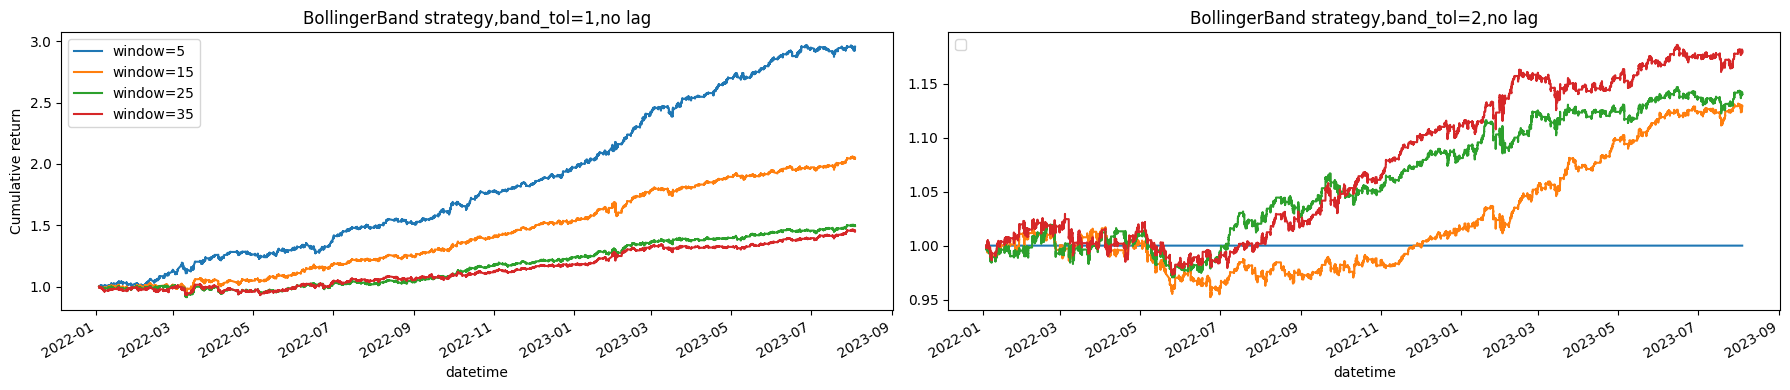

Indicator        Strategy  band tolerance  lookback window  lag  \
0   BollingerBand  Mean reversion               1                5    2   
1   BollingerBand  Mean reversion               1                5    3   
2   BollingerBand  Mean reversion               1                5    4   
3   BollingerBand  Mean reversion               1               15    2   
4   BollingerBand  Mean reversion               1               15    3   
5   BollingerBand  Mean reversion               1               15    4   
6   BollingerBand  Mean reversion               1               25    2   
7   BollingerBand  Mean reversion               1               25    3   
8   BollingerBand  Mean reversion               1               25    4   
9   BollingerBand  Mean reversion               1               35    2   
10  BollingerBand  Mean reversion               1               35    3   
11  BollingerBand  Mean reversion               1               35    4   
12  BollingerBand  Mean reversion               2                5    2   
13  BollingerBand  Mean reversion               2                5    3   
14  BollingerBand  Mean reversion               2                5    4   
15  BollingerBand  Mean reversion               2               15    2   
16  BollingerBand  Mean reversion               2               15    3   
17  BollingerBand  Mean reversion               2               15    4   
18  BollingerBand  Mean reversion               2               25    2   
19  BollingerBand  Mean reversion               2               25    3   
20  BollingerBand  Mean reversion               2               25    4   
21  BollingerBand  Mean reversion               2               35    2   
22  BollingerBand  Mean reversion               2               35    3   
23  BollingerBand  Mean reversion               2               35    4   

    holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0              1.9           3.8            3.2      0.002126 -0.000529   
1              1.9          -0.3           -0.3      0.115800 -0.000537   
2              1.9          -1.1           -0.9      0.251454 -0.000536   
3              3.5           2.4            2.0      0.021917 -0.000548   
4              3.5          -0.4           -0.3      0.169195 -0.000551   
5              3.5          -0.1           -0.1      0.155965 -0.000547   
6              4.7           1.0            0.9      0.048904 -0.000562   
7              4.7          -0.8           -0.7      0.188027 -0.000564   
8              4.7          -0.8           -0.7      0.194526 -0.000559   
9              5.6           0.7            0.6      0.098640 -0.000568   
10             5.6          -0.5           -0.5      0.150100 -0.000569   
11             5.6          -0.7           -0.6      0.192855 -0.000566   
12             0.0          -inf            0.0     -0.000000  0.000000   
13             0.0          -inf            0.0     -0.000000  0.000000   
14             0.0          -inf            0.0     -0.000000  0.000000   
15             1.7           1.5            0.7      0.005462 -0.000007   
16             1.7          -1.0           -0.4      0.125370 -0.000023   
17             1.7           0.3            0.1      0.047969 -0.000020   
18             2.3           0.8            0.3      0.027238 -0.000072   
19             2.3           0.2            0.1      0.037127 -0.000079   
20             2.3          -0.5           -0.3      0.066969 -0.000080   
21             2.7           0.3            0.1      0.039134 -0.000098   
22             2.7           0.2            0.1      0.039681 -0.000104   
23             2.7          -0.2           -0.1      0.058376 -0.000107   

    Expected shortfall(95%)  Ann. return  Ann. vol  
0                 -0.000973        0.531     0.136  
1                 -0.000962       -0.019     0.128  
2                 -0.000961       -0.115     0.128  
3                 -0.000990        0.336    

In [ ]:
BB_meanrev_is,BB_meanrev_ts_is = test_robustness(data_ins.copy(),
                                                 indicator='BollingerBand',
                                                 multiplier=1, # 1 for mean reversion, -1 for momentum
                                                 lookback_window=lookback_window,
                                                 band_tol=band_tolerance, lags=lags)

In [ ]:
# BB_meanrev_ts_is['signal']['b1w5l2'].head(10)#.plot(figsize=(12,5),title='Bollinger Bands discrete signal evolution')

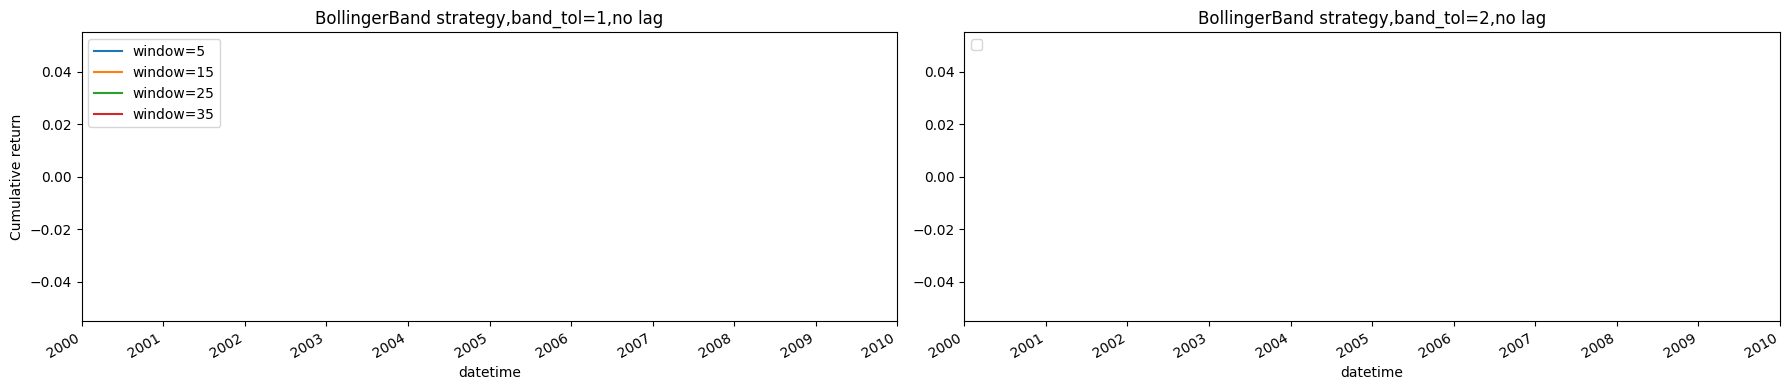

Indicator        Strategy  band tolerance  lookback window  lag  \
0   BollingerBand  Mean reversion               1                5    2   
1   BollingerBand  Mean reversion               1                5    3   
2   BollingerBand  Mean reversion               1                5    4   
3   BollingerBand  Mean reversion               1               15    2   
4   BollingerBand  Mean reversion               1               15    3   
5   BollingerBand  Mean reversion               1               15    4   
6   BollingerBand  Mean reversion               1               25    2   
7   BollingerBand  Mean reversion               1               25    3   
8   BollingerBand  Mean reversion               1               25    4   
9   BollingerBand  Mean reversion               1               35    2   
10  BollingerBand  Mean reversion               1               35    3   
11  BollingerBand  Mean reversion               1               35    4   
12  BollingerBand  Mean reversion               2                5    2   
13  BollingerBand  Mean reversion               2                5    3   
14  BollingerBand  Mean reversion               2                5    4   
15  BollingerBand  Mean reversion               2               15    2   
16  BollingerBand  Mean reversion               2               15    3   
17  BollingerBand  Mean reversion               2               15    4   
18  BollingerBand  Mean reversion               2               25    2   
19  BollingerBand  Mean reversion               2               25    3   
20  BollingerBand  Mean reversion               2               25    4   
21  BollingerBand  Mean reversion               2               35    2   
22  BollingerBand  Mean reversion               2               35    3   
23  BollingerBand  Mean reversion               2               35    4   

    holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0              1.9           3.4            3.1      0.010546 -0.000354   
1              1.9           1.4            1.2      0.030755 -0.000342   
2              1.9           1.2            1.1      0.021227 -0.000344   
3              3.3           2.0            1.7      0.023557 -0.000359   
4              3.3           1.0            0.8      0.017014 -0.000352   
5              3.3           1.0            0.8      0.014016 -0.000353   
6              4.4           1.2            1.0      0.012350 -0.000365   
7              4.4           0.8            0.6      0.012082 -0.000358   
8              4.4           0.2            0.2      0.013385 -0.000358   
9              5.2           0.5            0.5      0.012545 -0.000368   
10             5.2          -0.0           -0.0      0.019802 -0.000366   
11             5.2          -1.1           -0.9      0.059726 -0.000365   
12             0.0          -inf            0.0      0.000000  0.000000   
13             0.0          -inf            0.0      0.000000  0.000000   
14             0.0          -inf            0.0      0.000000  0.000000   
15             1.7           2.6            1.1      0.010374 -0.000003   
16             1.7          -2.0           -0.8      0.042380 -0.000019   
17             1.7           0.5            0.2      0.008537 -0.000017   
18             2.3          -0.6           -0.2      0.025422 -0.000053   
19             2.3          -1.3           -0.6      0.034928 -0.000059   
20             2.3          -0.1           -0.0      0.012987 -0.000054   
21             2.8          -0.6           -0.3      0.032724 -0.000068   
22             2.8          -2.1           -1.0      0.041154 -0.000071   
23             2.8          -2.6           -1.2      0.054351 -0.000068   

    Expected shortfall(95%)  Ann. return  Ann. vol  
0                 -0.000649        0.323     0.090  
1                 -0.000640        0.145     0.088  
2                 -0.000622        0.119     0.083  
3                 -0.000681        0.200    

In [ ]:
BB_meanrev_oos,BB_meanrev_ts_oos = test_robustness(data_oos.copy(),
                                                   indicator='BollingerBand',
                                                   multiplier= 1, # 1 for mean reversion, -1 for momentum
                                                   lookback_window=lookback_window,
                                                   band_tol=band_tolerance,
                                                   lags=lags)

<Axes: title={'center': 'Bollinger Bands strategy evolution'}, xlabel='datetime'>

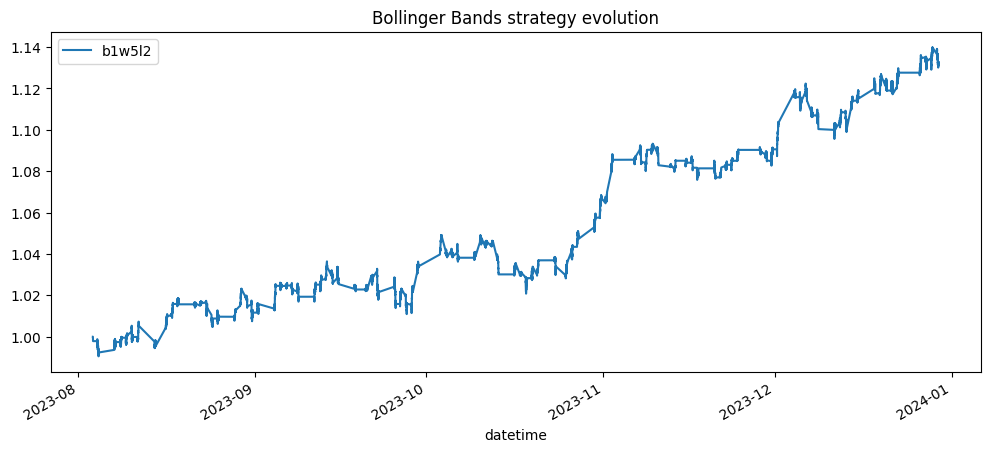

In [ ]:
# strategy_ts_oos['b1w5l2']['signal'].plot(figsize=(12,5),title='Bollinger Bands discrete signal evolution')
(1+BB_meanrev_ts_oos['strategy_returns']['b1w5l2']).cumprod().plot(figsize=(12,5),title='Bollinger Bands strategy evolution')

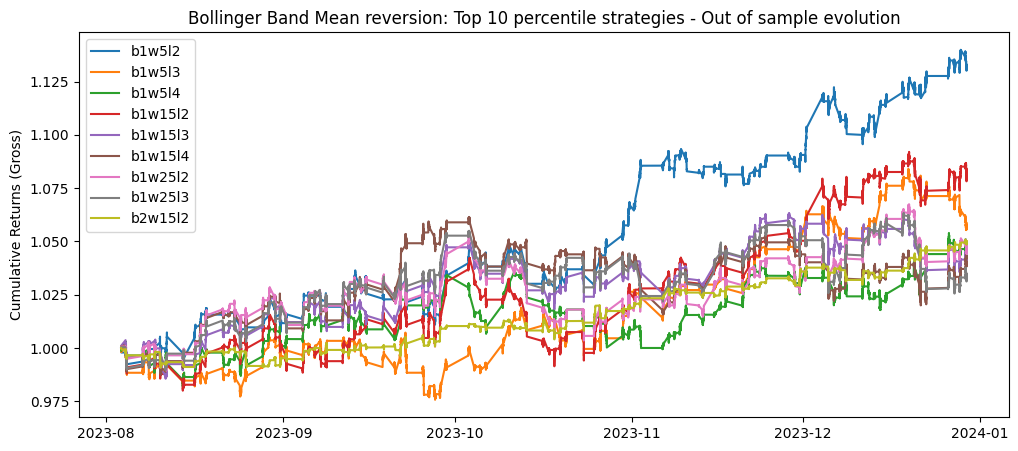

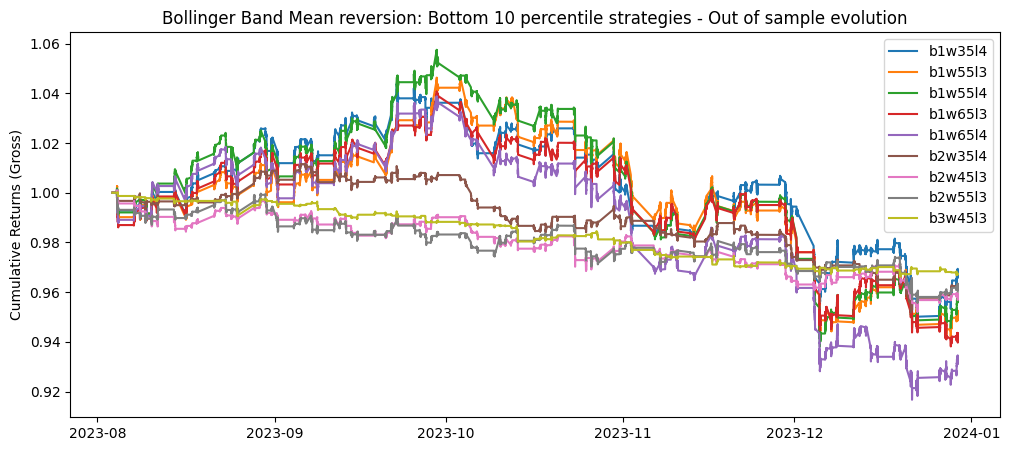

In [ ]:
percentile_charts(BB_meanrev_ts_oos,90,'Bollinger Band Mean reversion')

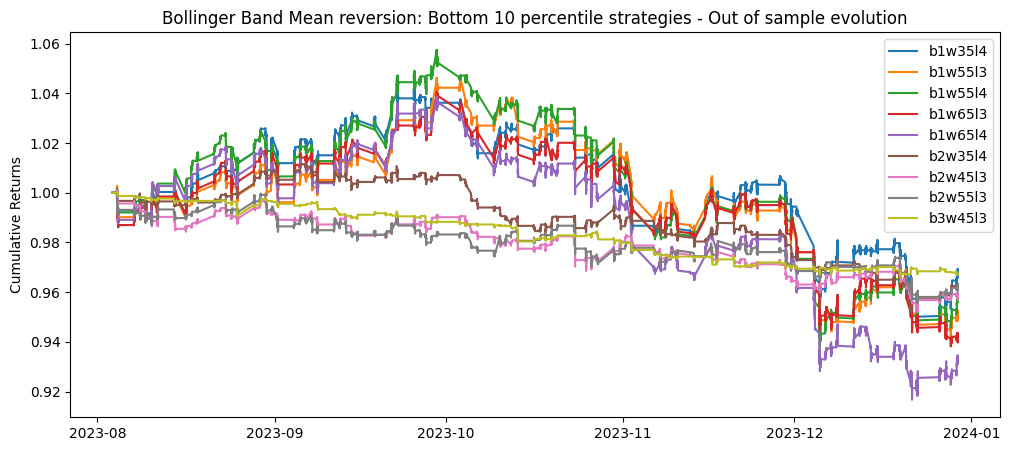

In [ ]:
# Get final values for all strategies
final_values = [data.iloc[-1,0] for data in BB_meanrev_ts_oos['cumulative_returns'].values()]

# Calculate 90th percentile
percentile_10 = np.percentile(final_values, 10)

plt.figure(figsize=(12, 5))
for strategy, data in BB_meanrev_ts_oos['cumulative_returns'].items():
    if data.iloc[-1,0] < percentile_10:
        plt.plot(data, label=strategy)  # Plot data with strategy as label

plt.title('Bollinger Band Mean reversion: Bottom 10 percentile strategies - Out of sample evolution')
plt.ylabel('Cumulative Returns')  # Add y-axis label
plt.legend()  # Display legend to identify strategies
plt.show()

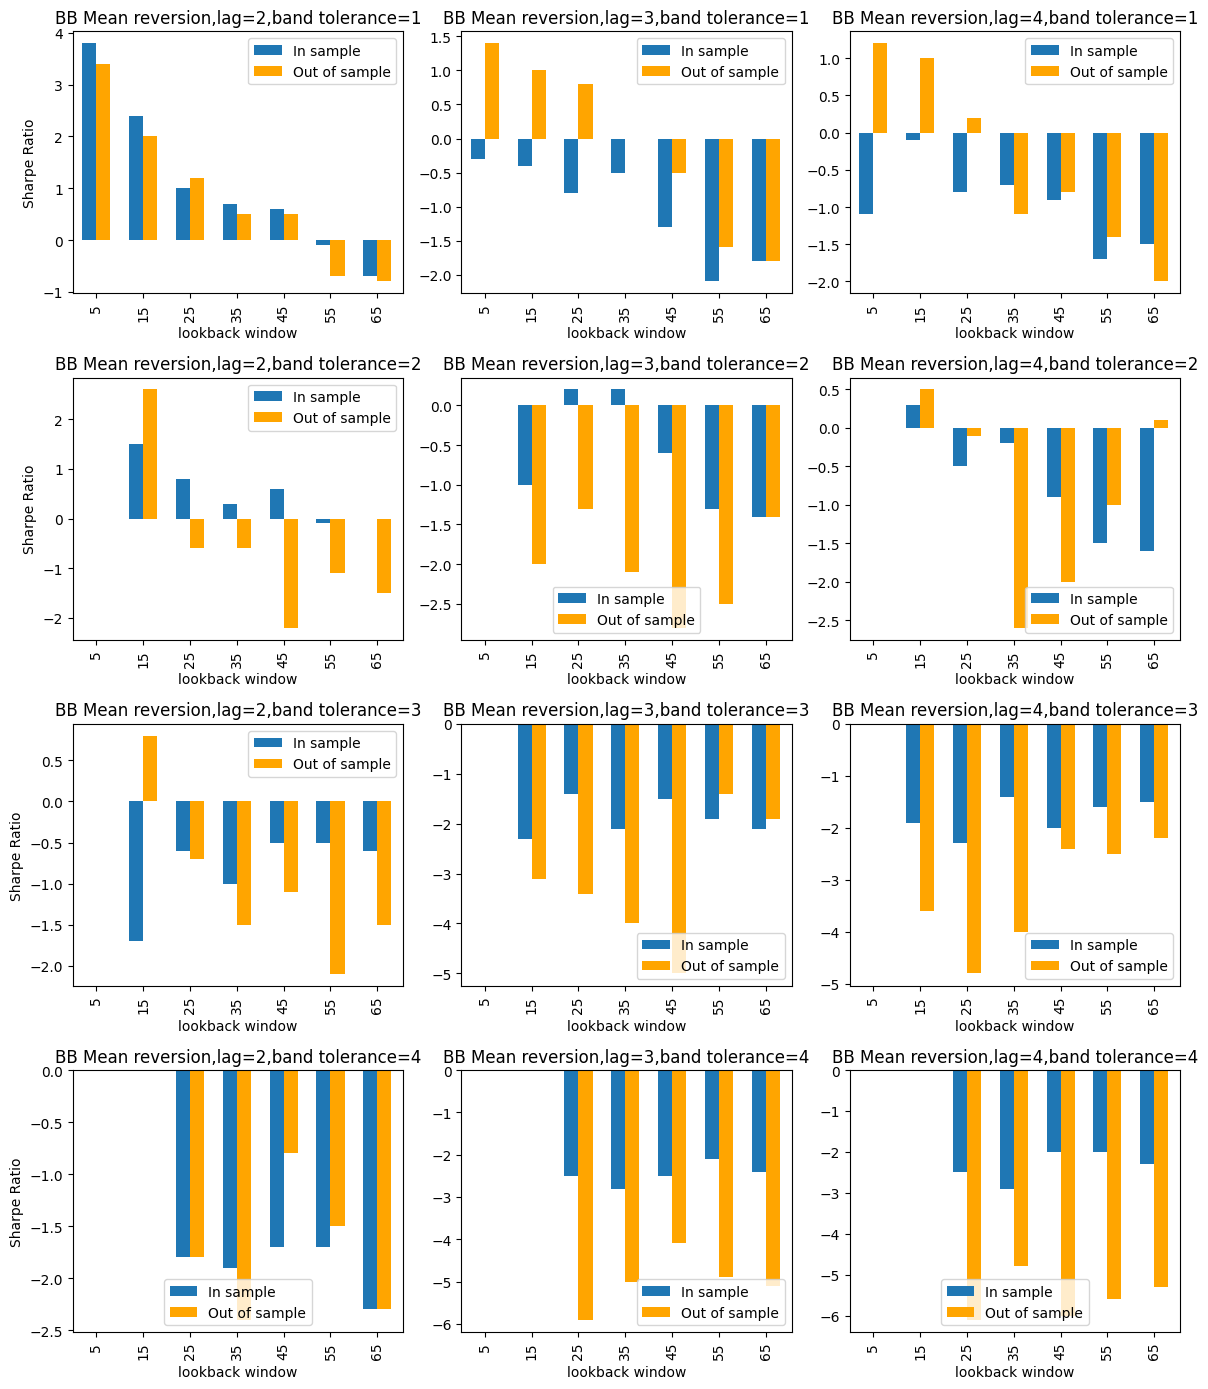

In [ ]:
robust_attribute_dict ={
    'y':'Sharpe Ratio', # could be changed to max drawdown, sortino ratio, etc
    'x':'lookback window',
    'row':'lag',
    'col':'band tolerance'
}

plot_robustness(BB_meanrev_is,BB_meanrev_oos,robust_attribute_dict,label='BB Mean reversion')

In [ ]:
# BB_meanrev_is.loc[BB_meanrev_is['Sharpe Ratio']>1]
pd.concat([BB_meanrev_ts_is['signal']['b1w5l2'],
           BB_meanrev_ts_oos['signal']['b1w5l2']],axis=0
          ).to_csv('/content/trading_signals_Bollinger_bands_rev.csv')

In [ ]:
# prompt: how to count number of instances 1 occurs in BB_meanrev_ts_is['signal']['b1w5l2']

count_1 = (BB_meanrev_ts_is['signal']['b1w15l2'] == -1).sum()
print(f"Number of instances where 'b1w5l2' signal is 1: {count_1}")

Number of instances where 'b1w5l2' signal is 1: b1w15l2    36914
dtype: int64


- There is rather a strong trend behaviour (Mean reversion sharpe is quite negative) at higher lags as mean reversion alpha decays very fast. Same behaviour at higher Bollinger bands (2 and beyond). Just shows that prices are not going to revert to mean at longer periods and beyond certain bands. Prices revert to mean very fast (lag 1 or 2 max).
- Caveat: Our holding period is usually short. We could make our exit strategy more smarter and see what the effect is for holding for longer?

In [ ]:
lookback_window = {'start':15,
                   'step':15,
                   'end':125}# exclusive
band_tolerance = {'start':1,
                  'step':1,
                  'end':4}#inclusive
lags = {'start':2, #Shift the signal by 2 or more for realistic implementation
        'step':1,
        'end':4}#inclusive

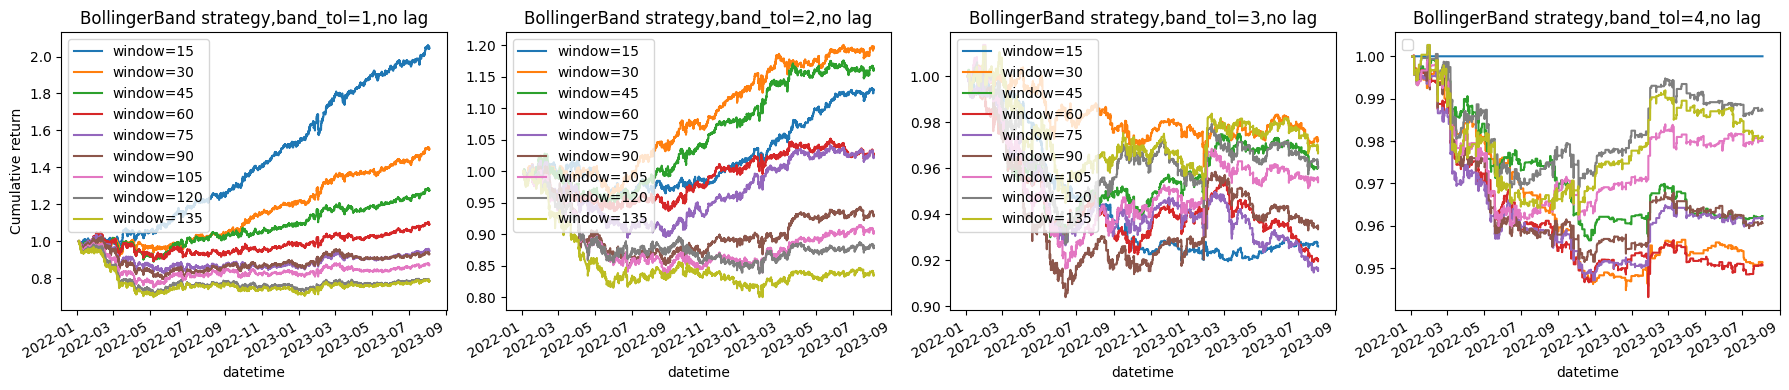

Indicator  Strategy  band tolerance  lookback window  lag  \
0    BollingerBand  Momentum               1               15    2   
1    BollingerBand  Momentum               1               15    3   
2    BollingerBand  Momentum               1               15    4   
3    BollingerBand  Momentum               1               30    2   
4    BollingerBand  Momentum               1               30    3   
..             ...       ...             ...              ...  ...   
103  BollingerBand  Momentum               4              120    3   
104  BollingerBand  Momentum               4              120    4   
105  BollingerBand  Momentum               4              135    2   
106  BollingerBand  Momentum               4              135    3   
107  BollingerBand  Momentum               4              135    4   

     holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0               3.5          -2.7           -2.4      0.555894 -0.000544   
1               3.5           0.1            0.1      0.049048 -0.000536   
2               3.5          -0.2           -0.2      0.145074 -0.000535   
3               5.1          -1.5           -1.4      0.325868 -0.000551   
4               5.1           0.4            0.4      0.023105 -0.000543   
..              ...           ...            ...           ...       ...   
103             2.7          -0.2           -0.0      0.008253  0.000000   
104             2.7          -0.7           -0.1      0.008934  0.000000   
105             2.8          -1.5           -0.1      0.033584  0.000000   
106             2.8          -0.6           -0.1      0.006709  0.000000   
107             2.8          -1.3           -0.1      0.022065  0.000000   

     Expected shortfall(95%)  Ann. return  Ann. vol  
0                  -0.000949       -0.336     0.133  
1                  -0.000935        0.030     0.131  
2                  -0.000932       -0.003     0.128  
3                  -0.000964       -0.187     0.136  
4                  -0.000952        0.078     0.136  
..                       ...          ...       ...  
103                -0.000001        0.016     0.019  
104                -0.000001        0.007     0.018  
105                -0.000002       -0.010     0.020  
106                -0.000001        0.009     0.019  
107                -0.000001       -0.003     0.018  

[108 rows x 13 columns]

In [ ]:
BB_mom_is,BB_mom_ts_is = test_robustness(data_ins.copy(),
                                         indicator='BollingerBand',
                                         multiplier= -1, # 1 for mean reversion, -1 for momentum
                                         lookback_window=lookback_window,
                                         band_tol=band_tolerance, lags=lags)

In [ ]:
BB_mom_is[BB_mom_is['Sharpe Ratio']>=1.5]

Indicator  Strategy  band tolerance  lookback window  lag  \
10  BollingerBand  Momentum               1               60    3   
16  BollingerBand  Momentum               1               90    3   
20  BollingerBand  Momentum               1              105    4   
22  BollingerBand  Momentum               1              120    3   
41  BollingerBand  Momentum               2               75    4   
43  BollingerBand  Momentum               2               90    3   
44  BollingerBand  Momentum               2               90    4   
46  BollingerBand  Momentum               2              105    3   
47  BollingerBand  Momentum               2              105    4   
50  BollingerBand  Momentum               2              120    4   
52  BollingerBand  Momentum               2              135    3   
53  BollingerBand  Momentum               2              135    4   

    holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
10             7.6           1.7            1.6      0.034046 -0.000552   
16             9.6           1.6            1.5      0.005641 -0.000553   
20            10.5           1.7            1.5      0.001401 -0.000552   
22            11.4           1.5            1.4      0.003127 -0.000554   
41             4.3           1.9            1.0      0.006863 -0.000156   
43             4.8           1.7            0.9      0.012658 -0.000168   
44             4.8           1.8            0.9      0.016389 -0.000166   
46             5.3           1.5            0.8      0.009921 -0.000175   
47             5.3           1.8            0.9      0.021255 -0.000171   
50             5.8           1.8            0.8      0.034302 -0.000180   
52             6.4           1.5            0.7      0.009707 -0.000189   
53             6.4           1.7            0.9      0.010755 -0.000188   

    Expected shortfall(95%)  Ann. return  Ann. vol  
10                -0.000975        0.256     0.141  
16                -0.000983        0.246     0.142  
20                -0.000983        0.255     0.142  
22                -0.000989        0.233     0.144  
41                -0.000526        0.165     0.077  
43                -0.000539        0.153     0.078  
44                -0.000536        0.155     0.077  
46                -0.000549        0.133     0.077  
47                -0.000548        0.162     0.077  
50                -0.000564        0.164     0.081  
52                -0.000577        0.146     0.082  
53                -0.000575        0.167     0.085

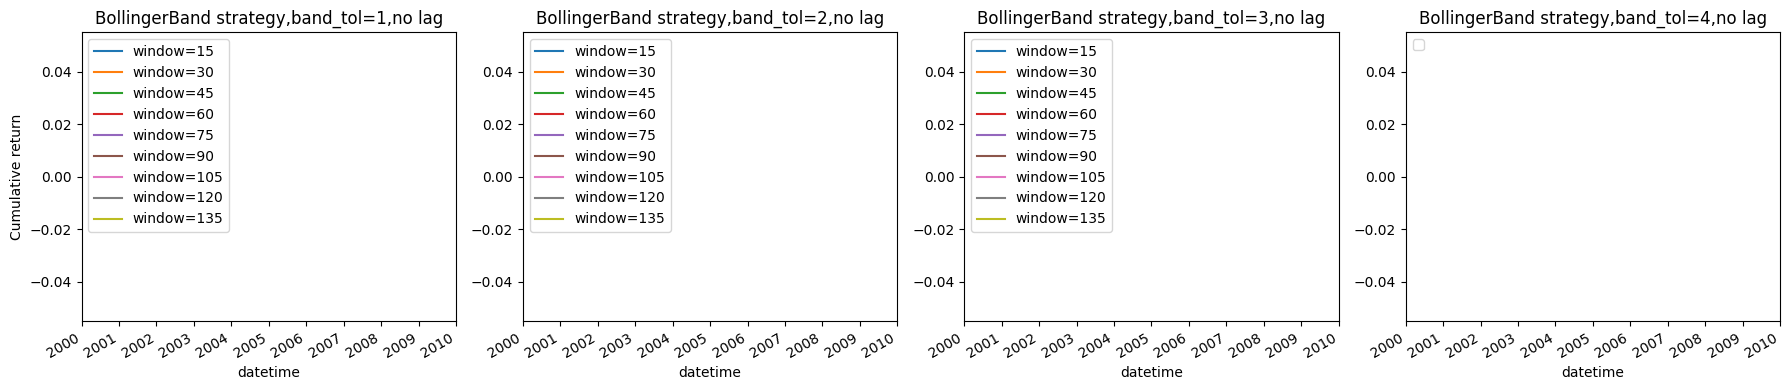

Indicator  Strategy  band tolerance  lookback window  lag  \
0    BollingerBand  Momentum               1               15    2   
1    BollingerBand  Momentum               1               15    3   
2    BollingerBand  Momentum               1               15    4   
3    BollingerBand  Momentum               1               30    2   
4    BollingerBand  Momentum               1               30    3   
..             ...       ...             ...              ...  ...   
103  BollingerBand  Momentum               4              120    3   
104  BollingerBand  Momentum               4              120    4   
105  BollingerBand  Momentum               4              135    2   
106  BollingerBand  Momentum               4              135    3   
107  BollingerBand  Momentum               4              135    4   

     holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0               3.3          -2.5           -2.2      0.097297 -0.000362   
1               3.3          -1.4           -1.4      0.071604 -0.000353   
2               3.3          -1.5           -1.4      0.066416 -0.000351   
3               4.9          -1.5           -1.4      0.063047 -0.000366   
4               4.9          -0.8           -0.8      0.048178 -0.000360   
..              ...           ...            ...           ...       ...   
103             3.1           0.7            0.1      0.000886  0.000000   
104             3.1           0.4            0.1      0.003116  0.000000   
105             3.2          -0.4           -0.0      0.001335  0.000000   
106             3.2           0.9            0.2      0.000886  0.000000   
107             3.2           1.2            0.2      0.004172  0.000000   

     Expected shortfall(95%)  Ann. return  Ann. vol  
0                  -0.000625       -0.200     0.090  
1                  -0.000612       -0.104     0.085  
2                  -0.000603       -0.102     0.082  
3                  -0.000614       -0.106     0.085  
4                  -0.000608       -0.045     0.083  
..                       ...          ...       ...  
103                -0.000001        0.028     0.011  
104                -0.000001        0.025     0.011  
105                -0.000002        0.015     0.014  
106                -0.000001        0.031     0.012  
107                -0.000001        0.034     0.011  

[108 rows x 13 columns]

In [ ]:
BB_mom_oos,BB_mom_ts_oos = test_robustness(data_oos.copy(),
                                           indicator='BollingerBand',
                                           multiplier= -1, # 1 for mean reversion, -1 for momentum
                                           lookback_window=lookback_window,
                                           band_tol=band_tolerance, lags=lags)

In [ ]:
# BB_mom_oos[BB_mom_oos['Sharpe Ratio']>=1.5]
pd.concat([BB_mom_ts_is['signal']['b2w45l3'],
           BB_mom_ts_oos['signal']['b2w45l3']],axis=0
          ).to_csv('/content/trading_signals_Bollinger_bands_mom.csv')

In [ ]:
threshold=0
# Find strategies with Sharpe ratio above 1 in both BB_mom_is and BB_mom_oos
strategies_above_1 = BB_mom_is[(BB_mom_is['Sharpe Ratio'] > threshold)]
strategies_above_1_both = strategies_above_1.merge(
    BB_mom_oos[BB_mom_oos['Sharpe Ratio'] > threshold],
    on=['Indicator', 'Strategy', 'band tolerance', 'lookback window', 'lag', 'holding period'],
    how='inner',
    suffixes=('_is', '_oos')
)

strategies_above_1_both

Indicator  Strategy  band tolerance  lookback window  lag  \
0  BollingerBand  Momentum               2               15    3   

   holding period  Sharpe Ratio_is  Sortino Ratio_is  Max Drawdown_is  \
0             1.7              0.3               0.1         0.012316   

   VaR(95%)_is  Expected shortfall(95%)_is  Ann. return_is  Ann. vol_is  \
0    -0.000039                   -0.000386           0.035        0.054   

   Sharpe Ratio_oos  Sortino Ratio_oos  Max Drawdown_oos  VaR(95%)_oos  \
0               1.0                0.5          0.002598     -0.000035   

   Expected shortfall(95%)_oos  Ann. return_oos  Ann. vol_oos  
0                    -0.000272            0.058         0.039

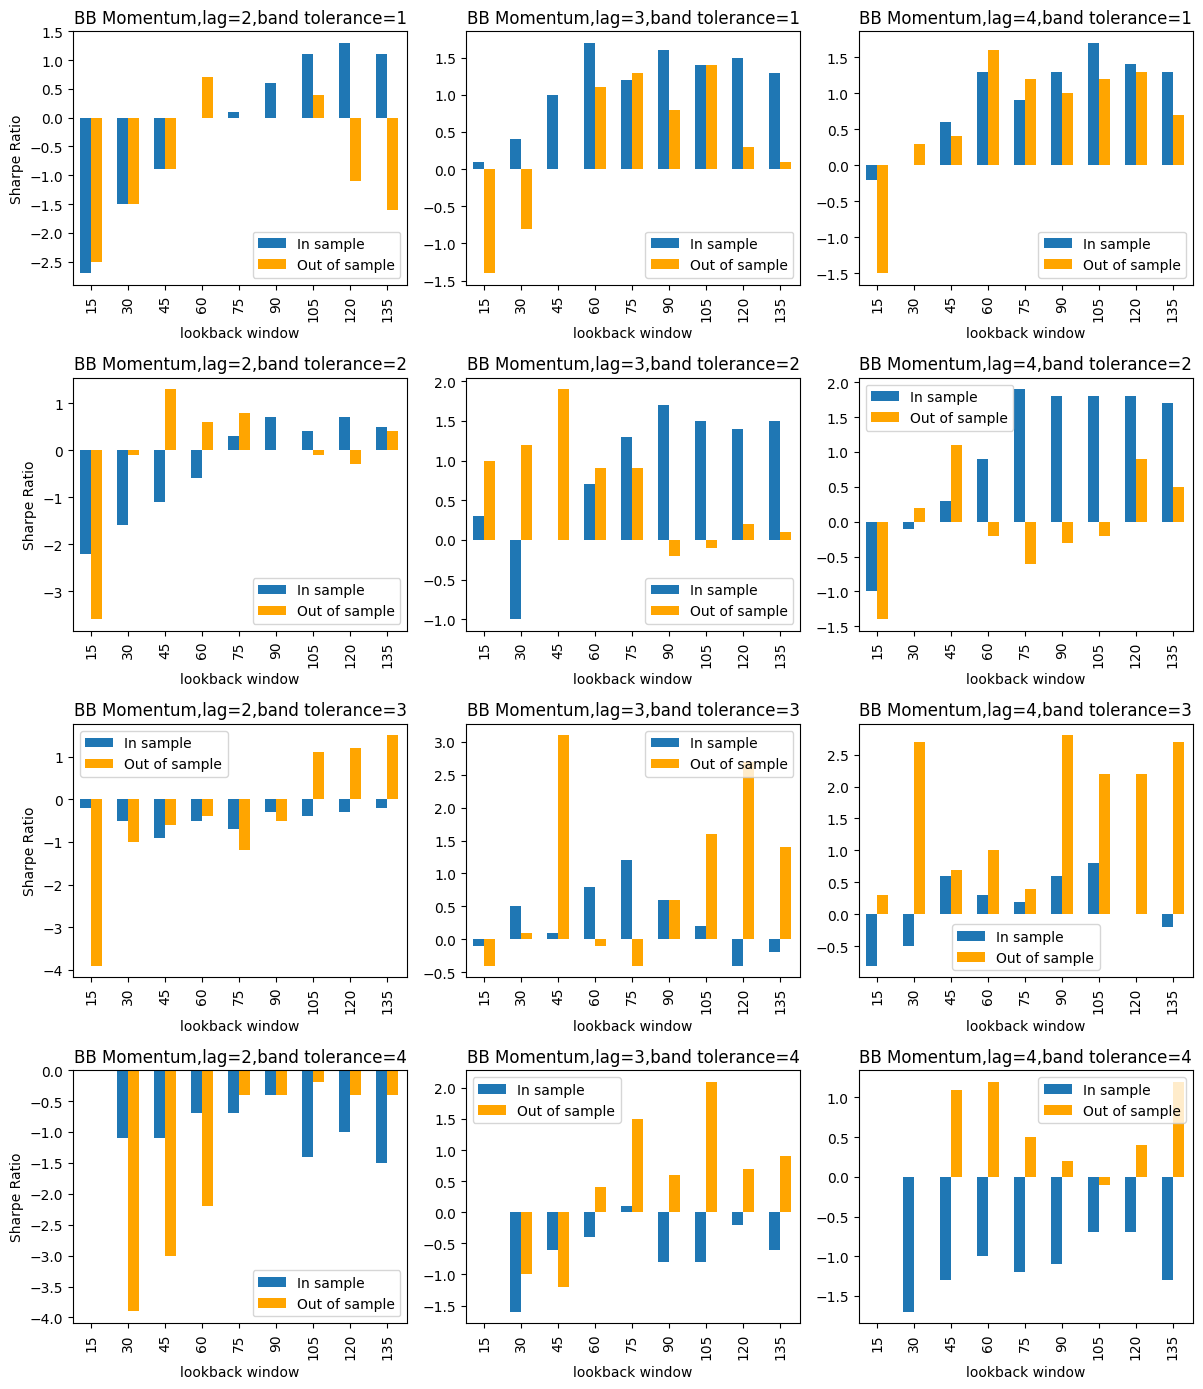

In [ ]:
robust_attribute_dict ={
    'y':'Sharpe Ratio', # could be changed to max drawdown, sortino ratio, etc
    'x':'lookback window',
    'row':'lag',
    'col':'band tolerance'
}

# Check that you are passing correct insample and out of sample dataframes
# Attribute dict argument is unchanged unless you'd like to plot max drawdown,etc

### UPDATE the label below to your strategy

plot_robustness(BB_mom_is,BB_mom_oos,robust_attribute_dict,label='BB Momentum')


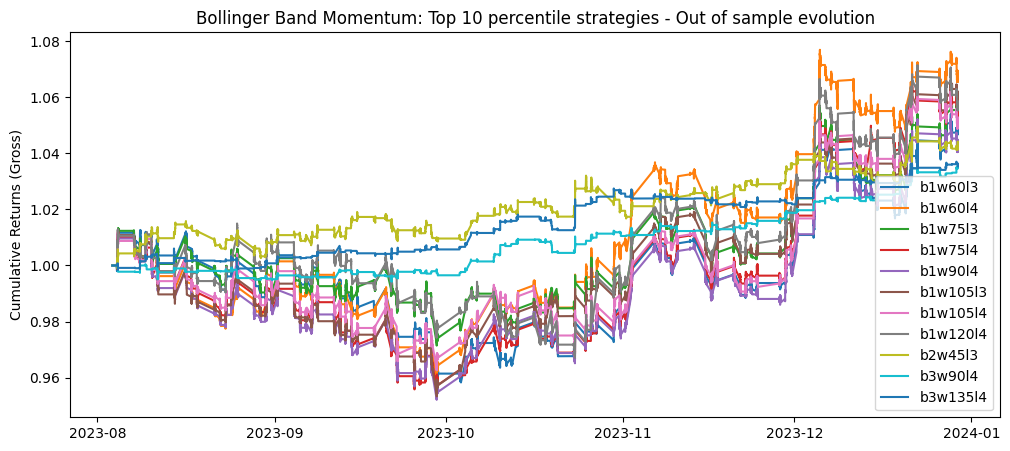

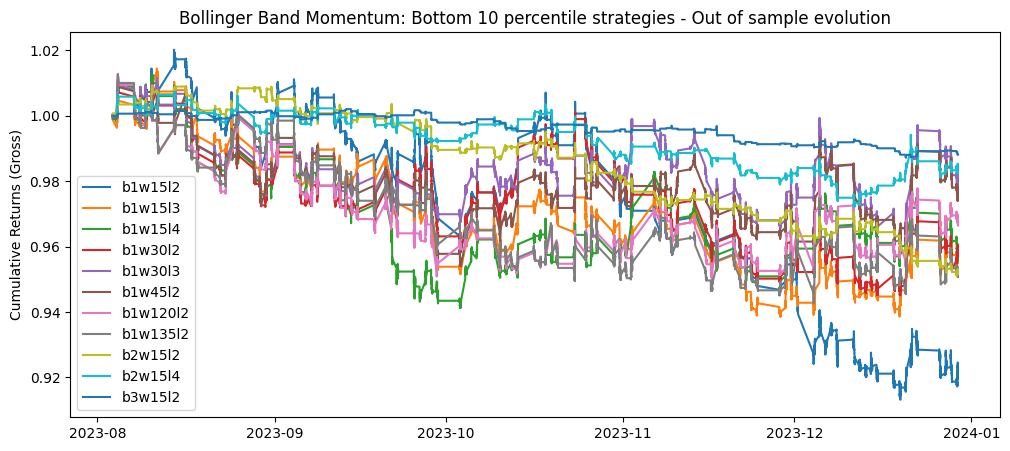

In [ ]:
percentile_charts(BB_mom_ts_oos,90,'Bollinger Band Momentum')

##3.2 Average True range

In [ ]:
lookback_window = {'start':10,
                   'step':10,
                   'end':120}# exclusive
band_tolerance = {'start':0,
                  'step':1,
                  'end':3}#inclusive
lags = {'start':2, #Shift the signal by 2 or more for realistic implementation
        'step':1,
        'end':4}#inclusive

In [ ]:
atr, ub, lb, atr_signal,signal = st.atr_signal(data_ins.copy(),window=65,ts_hl=120,
                                        smoothing_hl=20,threshold=0)

In [ ]:
_, _, _, _,signal_oos = st.atr_signal(data_oos.copy(),window=65,ts_hl=120,
                                      smoothing_hl=20,threshold=0)

In [ ]:
pd.concat([pd.DataFrame(signal,
                        index=data_ins[-len(signal):].index,columns=['b1w65l3']),
           pd.DataFrame(signal_oos,
                        index=data_oos[-len(signal_oos):].index,columns=['b1w65l3'])],
           axis=0).to_csv('/content/trading_signals_ATR_rev.csv')

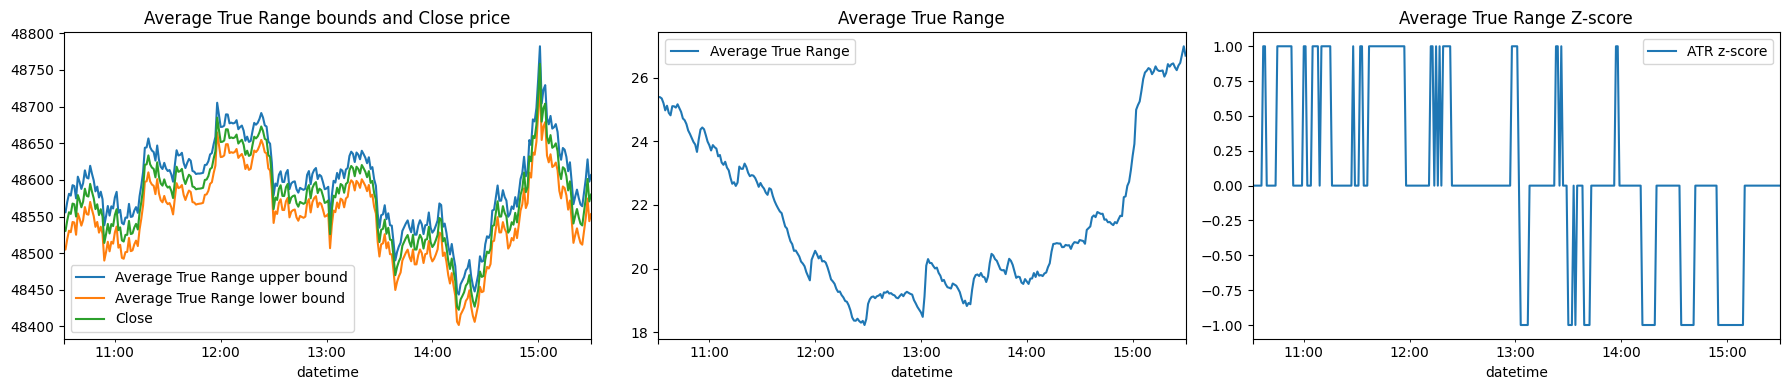

In [ ]:
indicator = 'Average True Range'
fig,ax = plt.subplots(1,3,figsize=(18,4))

pd.DataFrame({
              'Average True Range upper bound':ub,
              'Average True Range lower bound':lb,
              # 'atr':atr,
              'Close':bank_nifty_f1['close'],
              },index=bank_nifty_f1.index).tail(300).plot(ax=ax[0],title=f'{indicator} bounds and Close price')

pd.DataFrame({
              'Average True Range':atr,
              },index=bank_nifty_f1.index).tail(300).plot(ax=ax[1],title=f'{indicator}')

pd.DataFrame({
              'ATR z-score':atr_signal,
              },index=bank_nifty_f1[-len(atr_signal):].index).tail(300).plot(ax=ax[2],title=f'{indicator} signal')

# (1+pd.Series(atr_signal,index=bank_nifty_f1.index).shift(1)*bank_nifty_f1['return']).cumprod().plot(ax=ax[1],title=f'{indicator} signal strategy evolution')ion')

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Average True Range signal evolution'}, xlabel='datetime'>

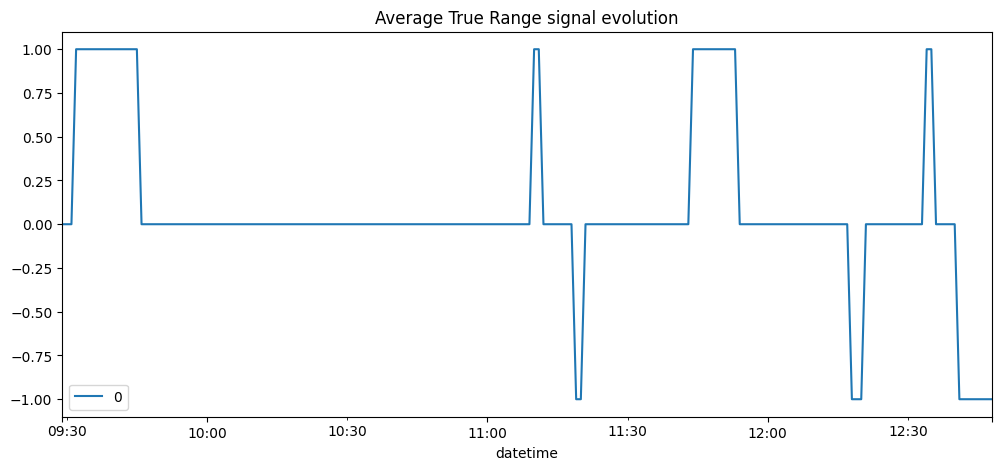

In [ ]:
pd.DataFrame(atr_signal, index=bank_nifty_f1[-len(atr_signal):].index).head(200).plot(figsize=(12,5),title=f'{indicator} signal evolution')

In [ ]:
# lookback_window = 60
# atr, ub, lb, atr_signal = st.atr_signal(bank_nifty_f1.copy(),window=lookback_window,
#                                         smoothing_hl=7)

# atr_z = ((atr[lookback_window-1:] - atr[lookback_window-1:].ewm(halflife=120).mean())/atr[lookback_window-1:].ewm(halflife=120).std())
# atr_z.dropna().head(300).plot()
# #

ValueError: too many values to unpack (expected 4)

<Axes: xlabel='datetime'>

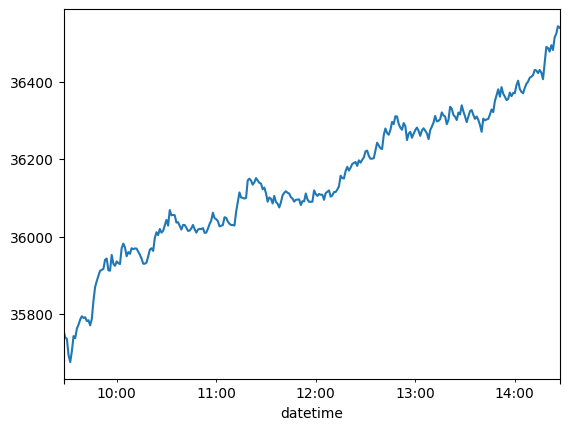

In [ ]:
data_ins['close'].reindex(atr[13:].index).head(300).plot()

<Axes: xlabel='datetime'>

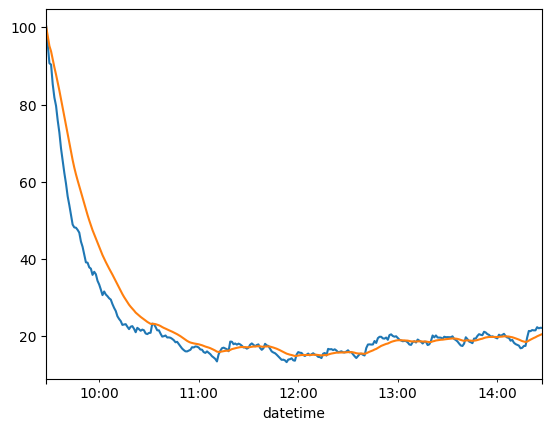

In [ ]:
atr[13:].head(300).plot()
atr[13:].ewm(halflife=7).mean().head(300).plot()

In [ ]:
threshold = 1.2
smoothing = 120
raw_sig = ((
    atr[13:] - atr[13:].ewm(halflife=smoothing).mean()
    )/atr[13:].ewm(halflife=smoothing).std()).dropna()
# signal = np.where(raw_sig < -1*threshold, 1, np.where(raw_sig > threshold, -1, 0))
# signal = pd.DataFrame(signal,raw_sig.index,columns=['signal'])
# signal = pd.concat([signal,data_ins['return'].reindex(signal.index)],axis=1)


In [ ]:
alpha = 0.05*raw_sig.ewm(halflife=20).std()*raw_sig
alpha

datetime
2022-01-03 10:14:00         NaN
2022-01-03 10:15:00    0.290642
2022-01-03 10:16:00    0.246098
2022-01-03 10:17:00    0.214334
2022-01-03 10:18:00    0.190334
                         ...   
2023-12-29 15:26:00    0.062142
2023-12-29 15:27:00    0.062161
2023-12-29 15:28:00    0.064743
2023-12-29 15:29:00    0.067114
2023-12-29 15:30:00    0.061910
Name: atr, Length: 184544, dtype: float64

<Axes: xlabel='datetime'>

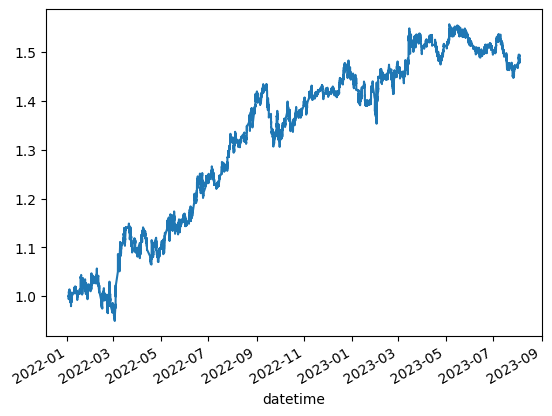

In [ ]:
new_signal = np.where(alpha<0,1,np.where(alpha>0,-1,0))
signal = pd.DataFrame(new_signal,raw_sig.index,columns=['signal'])
signal = pd.concat([signal,data_ins['return'].reindex(signal.index)],axis=1)
(1+signal['signal'].shift(2)*signal['return']).cumprod().plot()
# signal['new_signal'] = new_signal

<Axes: xlabel='datetime'>

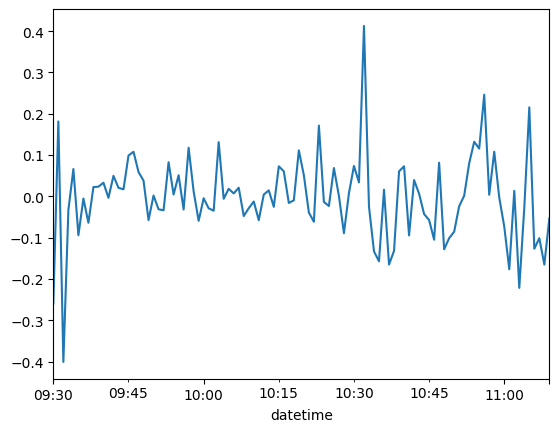

In [ ]:
((
    atr[13:] - atr[13:].ewm(halflife=7).mean()
    )/atr[13:].ewm(halflife=7).std()).dropna().diff().dropna().head(100).plot()

<Axes: xlabel='datetime'>

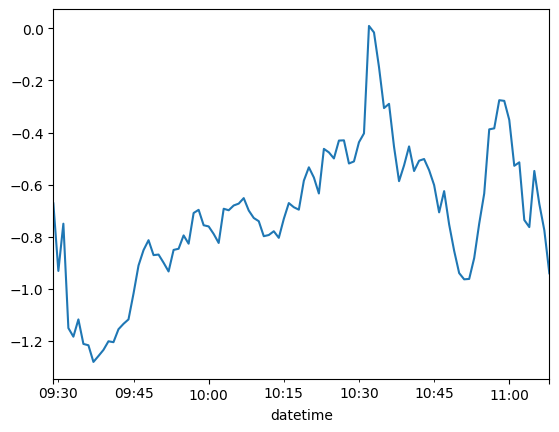

In [ ]:
((
    atr[13:] - atr[13:].ewm(halflife=7).mean()
    )/atr[13:].ewm(halflife=7).std()).dropna().head(100).plot()

In [ ]:
lookback_window = {'start':5,
                   'step':20,
                   'end':120}# exclusive
band_tolerance = {'start':0,
                  'step':0.2,
                  'end':1}#inclusive
lags = {'start':2, #Shift the signal by 2 or more for realistic implementation
        'step':1,
        'end':4}#inclusive

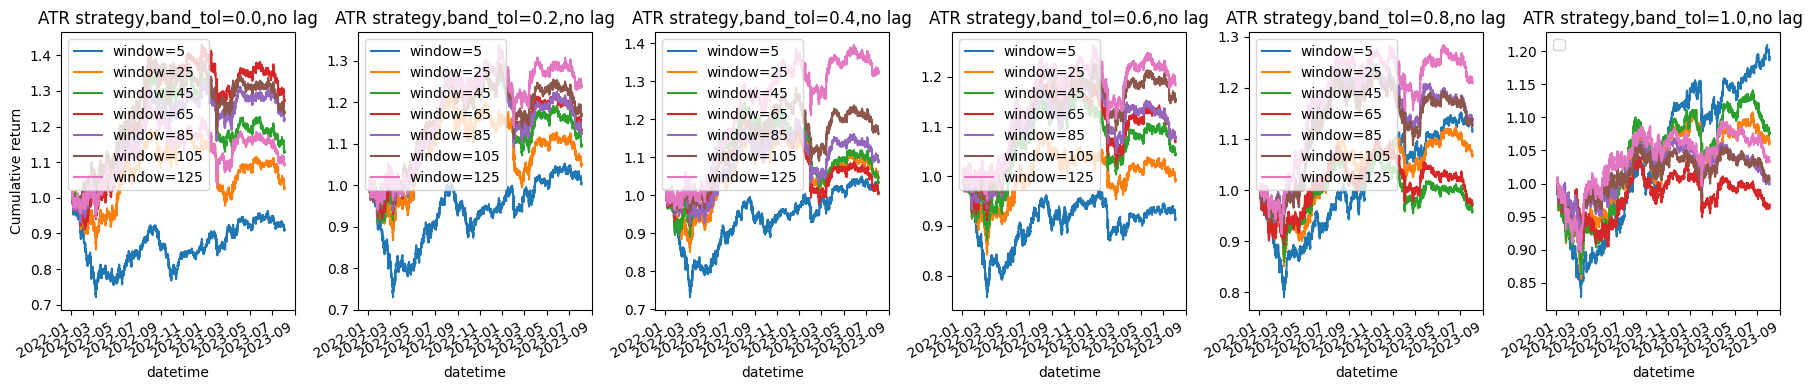

Indicator        Strategy  band tolerance  lookback window  lag  \
0         ATR  Mean reversion             0.0                5    2   
1         ATR  Mean reversion             0.0                5    3   
2         ATR  Mean reversion             0.0                5    4   
3         ATR  Mean reversion             0.0               25    2   
4         ATR  Mean reversion             0.0               25    3   
..        ...             ...             ...              ...  ...   
121       ATR  Mean reversion             1.0              105    3   
122       ATR  Mean reversion             1.0              105    4   
123       ATR  Mean reversion             1.0              125    2   
124       ATR  Mean reversion             1.0              125    3   
125       ATR  Mean reversion             1.0              125    4   

     holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0               7.7           0.4            0.5      0.215908 -0.000742   
1               7.7          -0.4           -0.4      0.244175 -0.000746   
2               7.7          -0.2           -0.3      0.155108 -0.000745   
3              20.2           0.2            0.2      0.152066 -0.000741   
4              20.2          -0.1           -0.1      0.206207 -0.000745   
..              ...           ...            ...           ...       ...   
121            11.3          -0.6           -0.4      0.153001 -0.000422   
122            11.3          -0.0           -0.0      0.100271 -0.000421   
123            11.6          -0.3           -0.2      0.134016 -0.000425   
124            11.6          -0.4           -0.3      0.126465 -0.000424   
125            11.6          -0.2           -0.1      0.079453 -0.000423   

     Expected shortfall(95%)  Ann. return  Ann. vol  
0                  -0.001249        0.100     0.186  
1                  -0.001252       -0.047     0.186  
2                  -0.001250       -0.022     0.186  
3                  -0.001239        0.054     0.186  
4                  -0.001241       -0.002     0.186  
..                       ...          ...       ...  
121                -0.000852       -0.052     0.119  
122                -0.000842        0.020     0.119  
123                -0.000853       -0.013     0.120  
124                -0.000853       -0.027     0.120  
125                -0.000844       -0.002     0.119  

[126 rows x 13 columns]

In [ ]:
atr_meanrev_is,atr_meanrev_ts_is = test_robustness(data_ins.copy(),
                                                   indicator='ATR',
                                                   multiplier=1, # 1 for mean reversion, -1 for momentum
                                                   lookback_window=lookback_window,
                                                   band_tol=band_tolerance,
                                                   lags=lags)

In [ ]:
atr_meanrev_is.loc[atr_meanrev_is['Sharpe Ratio']>0.3]

Indicator        Strategy  band tolerance  lookback window  lag  \
0        ATR  Mean reversion             0.0                5    2   
3        ATR  Mean reversion             0.0               15    2   
4        ATR  Mean reversion             0.0               15    3   
9        ATR  Mean reversion             0.0               35    2   
11       ATR  Mean reversion             0.0               35    4   
12       ATR  Mean reversion             0.0               45    2   
14       ATR  Mean reversion             0.0               45    4   
15       ATR  Mean reversion             0.0               55    2   
17       ATR  Mean reversion             0.0               55    4   
18       ATR  Mean reversion             0.0               65    2   
19       ATR  Mean reversion             0.0               65    3   
20       ATR  Mean reversion             0.0               65    4   
21       ATR  Mean reversion             0.2                5    2   
24       ATR  Mean reversion             0.2               15    2   
27       ATR  Mean reversion             0.2               25    2   
29       ATR  Mean reversion             0.2               25    4   
30       ATR  Mean reversion             0.2               35    2   
32       ATR  Mean reversion             0.2               35    4   
33       ATR  Mean reversion             0.2               45    2   
35       ATR  Mean reversion             0.2               45    4   
36       ATR  Mean reversion             0.2               55    2   
38       ATR  Mean reversion             0.2               55    4   
39       ATR  Mean reversion             0.2               65    2   
41       ATR  Mean reversion             0.2               65    4   
51       ATR  Mean reversion             0.4               35    2   
52       ATR  Mean reversion             0.4               35    3   
54       ATR  Mean reversion             0.4               45    2   
57       ATR  Mean reversion             0.4               55    2   
59       ATR  Mean reversion             0.4               55    4   
60       ATR  Mean reversion             0.4               65    2   
65       ATR  Mean reversion             0.6                5    4   
69       ATR  Mean reversion             0.6               25    2   
87       ATR  Mean reversion             0.8               15    2   

    holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0              7.7           0.4            0.5      0.215908 -0.000742   
3             14.9           0.6            0.7      0.132691 -0.000740   
4             14.9           0.4            0.5      0.165533 -0.000741   
9             24.2           0.5            0.7      0.078968 -0.000743   
11            24.2           0.6            0.8      0.114561 -0.000743   
12            27.6           0.4            0.5      0.112261 -0.000744   
14            27.6           0.4            0.5      0.082007 -0.000745   
15            30.8           0.6            0.8      0.112855 -0.000744   
17            30.8           0.7            0.8      0.054450 -0.000744   
18            32.8           1.0            1.2      0.075216 -0.000744   
19            32.8           0.5            0.7      0.070552 -0.000745   
20            32.8           0.6            0.7      0.065851 -0.000744   
21             6.5           0.4            0.5      0.213636 -0.000683   
24            13.0           0.4            0.4      0.155179 -0.000695   
27            17.7           0.4            0.5      0.096590 -0.000699   
29            17.7           0.5            0.5      0.094016 -0.000700   
30            21.3           0.4            0.4      0.123947 -0.000702   
32            21.3           0.6            0.7      0.093174 -0.000703   
33            24.5           0.7            0.9      0.085422 -0.000704   
35            24.5           0.5            0.6      0.080484 -0.000706   
36            27.0           0.6            0.7

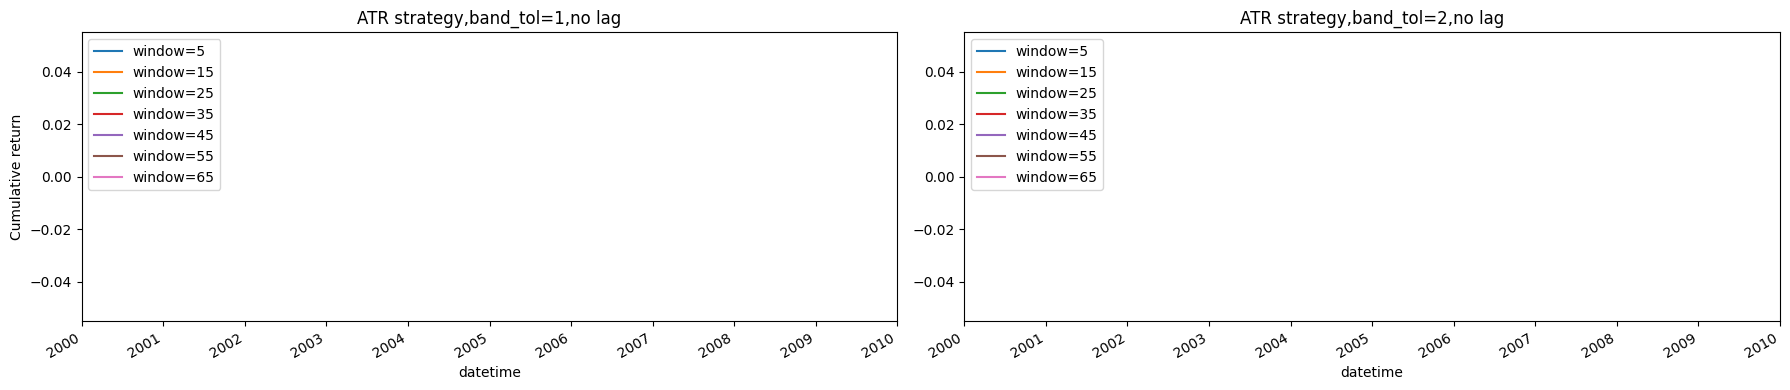

Indicator        Strategy  band tolerance  lookback window  lag  \
0        ATR  Mean reversion               0                5    2   
1        ATR  Mean reversion               0                5    3   
2        ATR  Mean reversion               0                5    4   
3        ATR  Mean reversion               0               15    2   
4        ATR  Mean reversion               0               15    3   
..       ...             ...             ...              ...  ...   
58       ATR  Mean reversion               2               55    3   
59       ATR  Mean reversion               2               55    4   
60       ATR  Mean reversion               2               65    2   
61       ATR  Mean reversion               2               65    3   
62       ATR  Mean reversion               2               65    4   

    holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0              8.2           0.4            0.5      0.056656 -0.000487   
1              8.2           0.6            0.7      0.064339 -0.000488   
2              8.2           2.0            2.5      0.022386 -0.000486   
3             15.6           2.9            3.7      0.018902 -0.000483   
4             15.6           2.7            3.4      0.021756 -0.000484   
..             ...           ...            ...           ...       ...   
58             4.4           0.2            0.0      0.002206  0.000000   
59             4.4          -0.4           -0.1      0.006736  0.000000   
60             4.4          -0.6           -0.1      0.003023  0.000000   
61             4.4          -0.2           -0.0      0.005925  0.000000   
62             4.4          -0.3           -0.1      0.006206  0.000000   

    Expected shortfall(95%)  Ann. return  Ann. vol  
0                 -0.000824        0.073     0.121  
1                 -0.000829        0.093     0.121  
2                 -0.000825        0.266     0.121  
3                 -0.000816        0.369     0.121  
4                 -0.000817        0.342     0.121  
..                      ...          ...       ...  
58                -0.000003        0.024     0.021  
59                -0.000003        0.011     0.020  
60                -0.000003        0.006     0.021  
61                -0.000003        0.015     0.021  
62                -0.000003        0.014     0.020  

[63 rows x 13 columns]

In [ ]:
atr_meanrev_oos,atr_meanrev_ts_oos = test_robustness(data_oos.copy(),
                                                     indicator='ATR',
                                                     multiplier=1, # 1 for mean reversion, -1 for momentum
                                                     lookback_window=lookback_window,
                                                     band_tol=band_tolerance,
                                                     lags=lags)

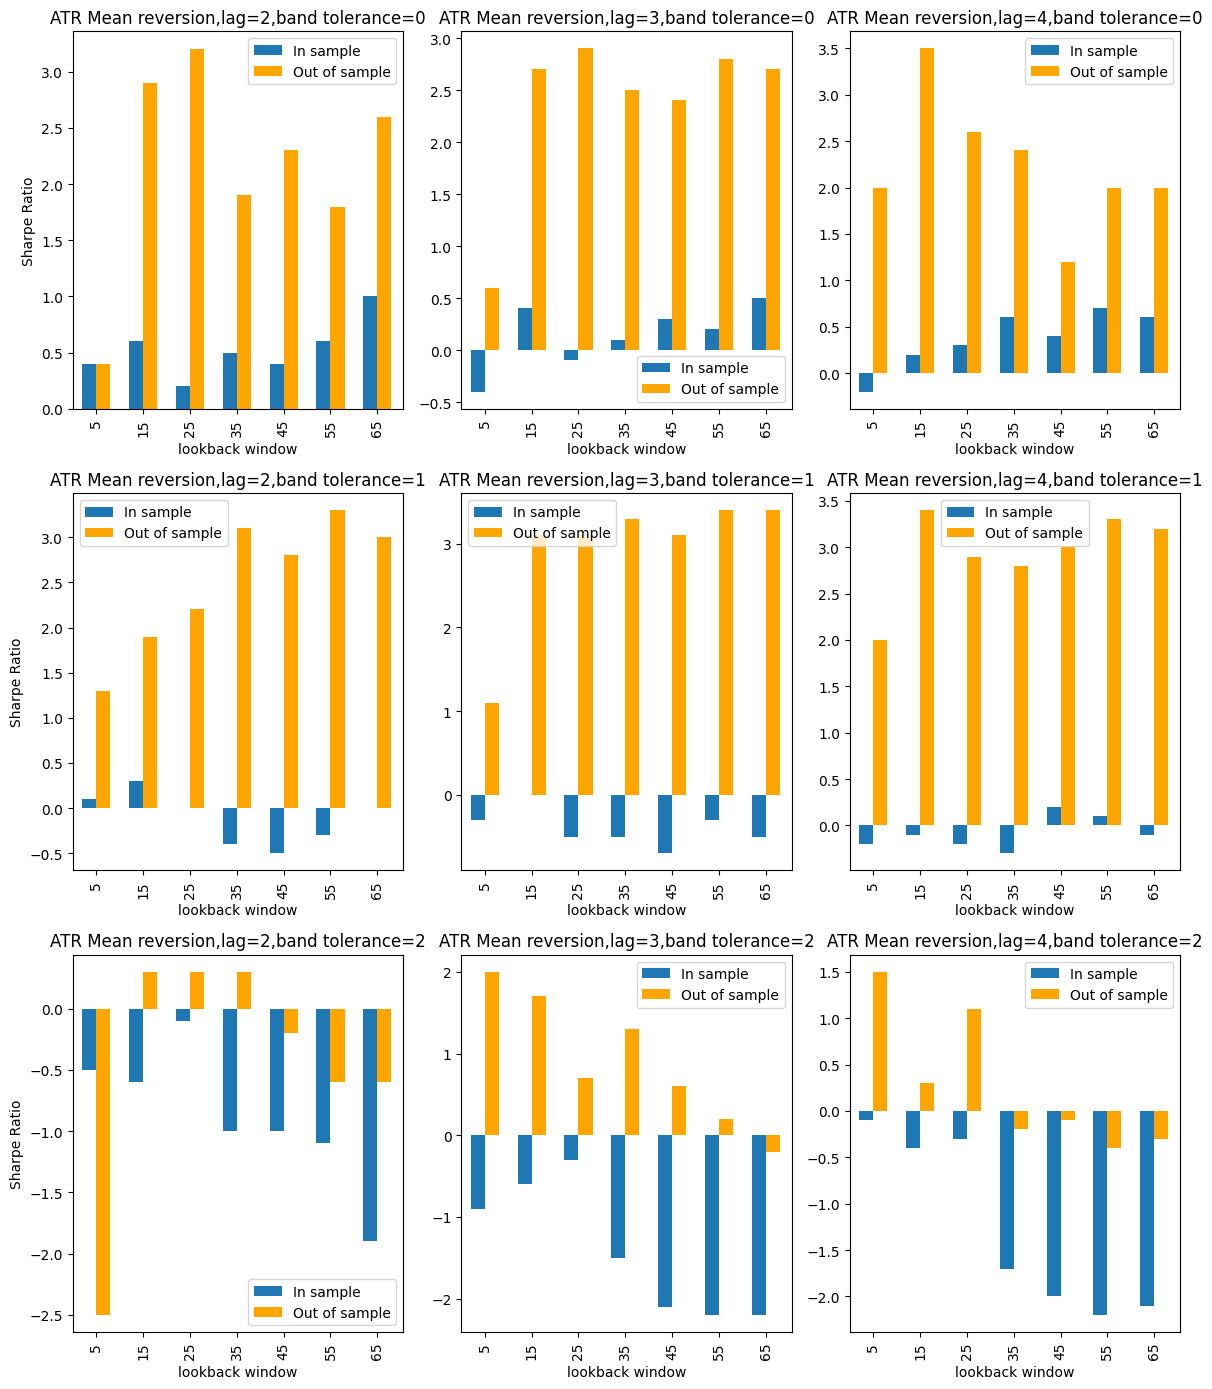

In [ ]:
robust_attribute_dict ={
    'y':'Sharpe Ratio', # could be changed to max drawdown, sortino ratio, etc
    'x':'lookback window',
    'row':'lag',
    'col':'band tolerance'
}
plot_robustness(atr_meanrev_is,atr_meanrev_oos,robust_attribute_dict,
                label='ATR Mean reversion')

In [ ]:
# for i,band_tol in enumerate(np.arange(band_tolerance['start'],band_tolerance['end']+band_tolerance['step'],
#                     band_tolerance['step'])):
#     print(f'{i}:{band_tol}'
#           )
len(np.arange(band_tolerance['start'],band_tolerance['end']+band_tolerance['step'],
                    band_tolerance['step']))

9

## 3.3 Keltner channel

In [ ]:
def test_robustness(data,indicator,multiplier,lookback_window,smoothing,lags):
    if multiplier not in (1, -1):
        raise ValueError("Multiplier must be either 1 or -1")
    results = []
    ts = {'signal': {}, 'strategy_returns': {}, 'cumulative_returns': {}}
    count_bands = len(np.arange(smoothing['start'],smoothing['end']+smoothing['step'],
                    smoothing['step']))
    fig,ax = plt.subplots(1,count_bands,figsize=(18,4))
    for i,smooth in enumerate(np.arange(smoothing['start'],smoothing['end']+smoothing['step'],
                          smoothing['step'])):
        legend = []
        smooth = smooth.round(1) if isinstance(smooth, float) else smooth
        # print(i)
        for window in range(lookback_window['start'],
                            lookback_window['end']+lookback_window['step'],
                            lookback_window['step']):
            _, _, signal = st.keltner_channel_signal(
                data,lookback_window=window,smoothing_window=smooth)

            (1+pd.Series(signal,index=data[-len(signal):].index).shift(1)*data['return'][-len(signal):]).cumprod().plot(
                title=f'{indicator} strategy,smoothing={smooth},no lag',ax=ax[i])
            legend.append(f'window={window}')
            for lag in range(lags['start'],lags['end']+lags['step'],lags['step']):
                data['signal'] = pd.Series(signal,
                                           index=data[-len(signal):].index
                                           ).shift(lag).fillna(0)
                strategy_returns = multiplier * data['signal'] * data['return']
                # Identify the start and end of holding periods
                data['holding'] = pd.Series(
                    signal,index=data[-len(signal):].index
                    ).shift(lag).diff().fillna(0).abs()
                data['holding'] = data['holding'].cumsum()
                # Calculate the duration of each holding period
                holding_periods = data[data['signal'] != 0].groupby('holding').size()
                # Check if holding_periods is empty, and if so, set holding_period to NaN
                # Otherwise calculate and round as before
                if holding_periods.empty:
                    holding_period = np.nan  # Use float('nan') for consistency
                else:
                    holding_period = holding_periods.mean().round(1)

                analytics = st.calculate_analytics(strategy_returns)
                results.append({
                    'Indicator': indicator,
                    'Strategy': 'Mean reversion' if multiplier==1 else 'Momentum',
                    'smoothing': smooth,
                    'lookback window': window,
                    'lag': lag,
                    'holding period': holding_period,
                    **analytics
                })
                key = f'b{smooth}w{window}l{lag}'
                ts['signal'][key] = data['signal'].to_frame(key)
                ts['strategy_returns'][key] = strategy_returns.to_frame(key)
                ts['cumulative_returns'][key] = (1+strategy_returns).cumprod().to_frame(key)

        ax[i-1].legend(legend,loc='upper left')
        if i==1:
            ax[i-1].set_ylabel('Cumulative return')
    plt.tight_layout()
    plt.show()

    analytics = pd.DataFrame(results).fillna(0)
    display(analytics)
    return analytics,ts

In [ ]:
keltner_high, keltner_low, keltner_signal = st.keltner_channel_signal(
    data_ins.copy(),lookback_window=20,smoothing_window=5)

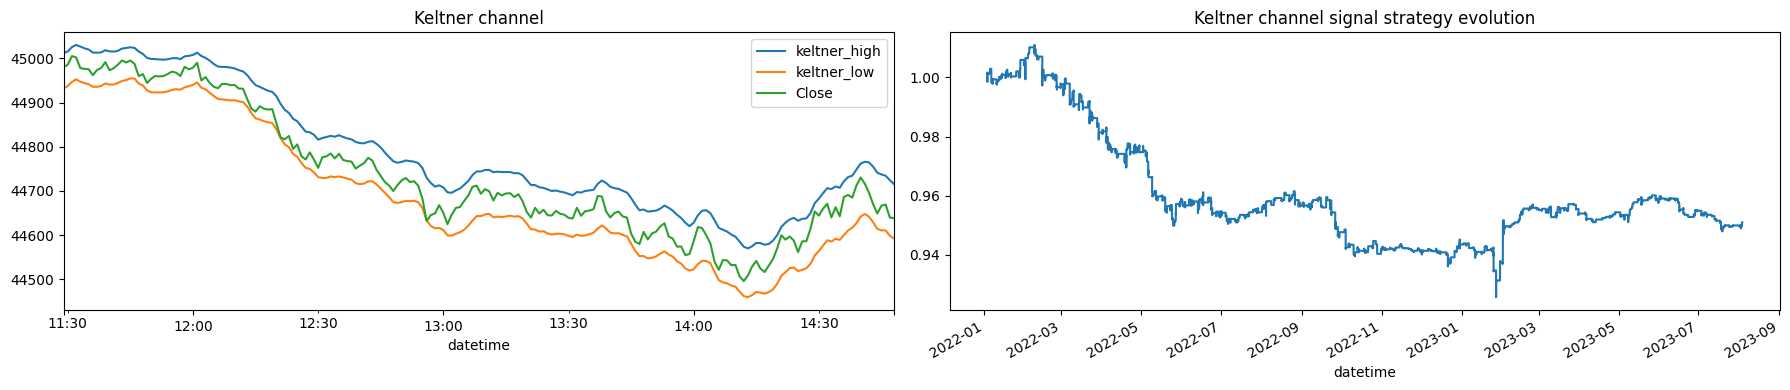

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,4))

pd.DataFrame({'keltner_high':keltner_high,
              'keltner_low':keltner_low,
              'Close':data_ins['close'],
              },index=data_ins.index).tail(200).plot(ax=ax[0],
                                                     title='Keltner channel')

(1+pd.Series(keltner_signal,index=data_ins.index).shift(1)*data_ins['return']
 ).cumprod().plot(ax=ax[1],title='Keltner channel signal strategy evolution')

# (1+pd.Series(bb_sig_cont,index=bank_nifty_f1.index).shift(1)*bank_nifty_f1['return']).cumprod().plot(ax=ax[2],title='Bollinger Bands continuous strategy evolution')

plt.tight_layout()
plt.show()

In [ ]:
lookback_window = {'start':5,
                   'step':10,
                   'end':60}# exclusive
smoothing = {'start':5,
                  'step':5,
                  'end':30}#inclusive
lags = {'start':2, #Shift the signal by 2 or more for realistic implementation
        'step':1,
        'end':4}#inclusive

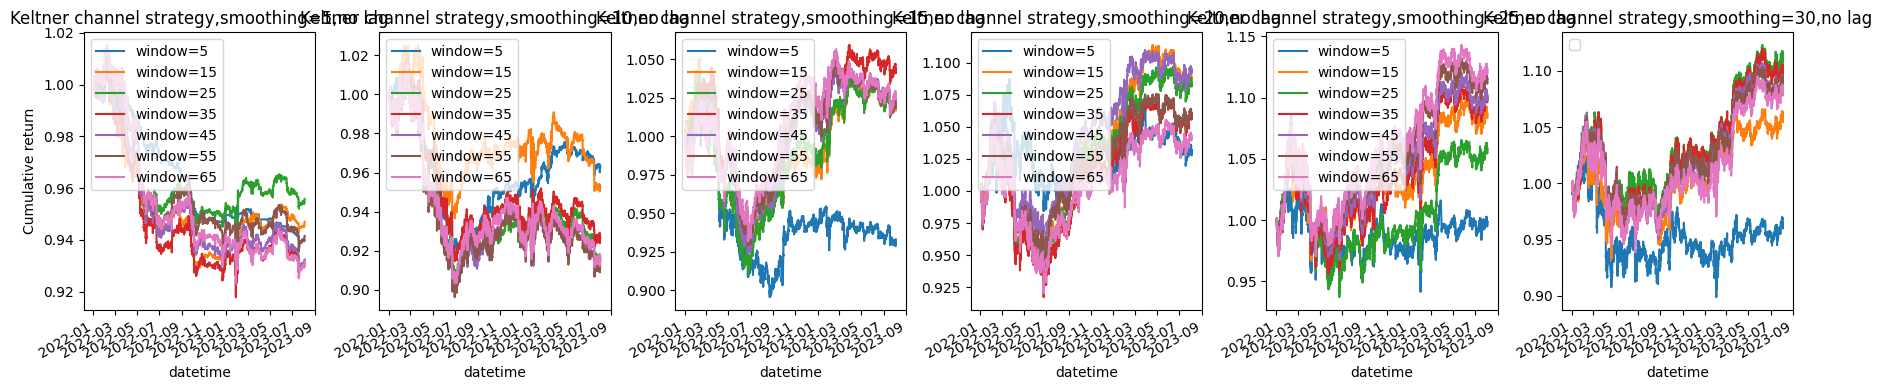

Indicator  Strategy  smoothing  lookback window  lag  \
0    Keltner channel  Momentum          5                5    2   
1    Keltner channel  Momentum          5                5    3   
2    Keltner channel  Momentum          5                5    4   
3    Keltner channel  Momentum          5               15    2   
4    Keltner channel  Momentum          5               15    3   
..               ...       ...        ...              ...  ...   
121  Keltner channel  Momentum         30               55    3   
122  Keltner channel  Momentum         30               55    4   
123  Keltner channel  Momentum         30               65    2   
124  Keltner channel  Momentum         30               65    3   
125  Keltner channel  Momentum         30               65    4   

     holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0               1.4          -0.9           -0.1      0.004451  0.000000   
1               1.4          -0.3           -0.0      0.001608  0.000000   
2               1.4          -0.9           -0.1      0.001578  0.000000   
3               1.7           0.1            0.0      0.010360  0.000000   
4               1.7          -0.3           -0.0      0.001523  0.000000   
..              ...           ...            ...           ...       ...   
121             4.7           0.0            0.0      0.046391 -0.000356   
122             4.7           1.1            0.7      0.008068 -0.000354   
123             4.7          -0.5           -0.3      0.120763 -0.000364   
124             4.7          -0.0           -0.0      0.045773 -0.000358   
125             4.7           1.1            0.7      0.009045 -0.000354   

     Expected shortfall(95%)  Ann. return  Ann. vol  
0              -5.767443e-07        0.009     0.012  
1              -5.015628e-07        0.016     0.011  
2              -5.518653e-07        0.009     0.012  
3              -2.196336e-06        0.022     0.025  
4              -2.065566e-06        0.014     0.022  
..                       ...          ...       ...  
121            -7.593998e-04        0.021     0.101  
122            -7.561177e-04        0.138     0.105  
123            -7.666912e-04       -0.030     0.103  
124            -7.614347e-04        0.019     0.101  
125            -7.585503e-04        0.137     0.105  

[126 rows x 13 columns]

In [ ]:
kc_mom_ins,kc_mom_ts_ins = test_robustness(
    data_ins.copy(),indicator='Keltner channel',multiplier=-1,
    lookback_window=lookback_window,smoothing=smoothing,lags=lags)

In [ ]:
# kc_mom_oos.loc[kc_mom_oos['lag']==3]

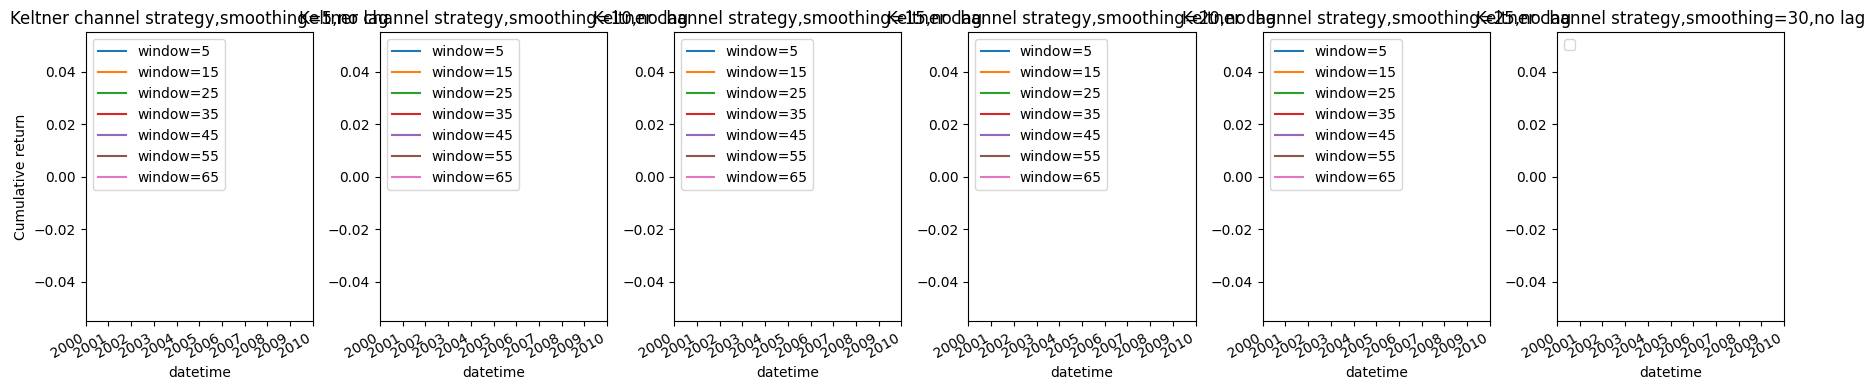

Indicator  Strategy  smoothing  lookback window  lag  \
0    Keltner channel  Momentum          5                5    2   
1    Keltner channel  Momentum          5                5    3   
2    Keltner channel  Momentum          5                5    4   
3    Keltner channel  Momentum          5               15    2   
4    Keltner channel  Momentum          5               15    3   
..               ...       ...        ...              ...  ...   
121  Keltner channel  Momentum         30               55    3   
122  Keltner channel  Momentum         30               55    4   
123  Keltner channel  Momentum         30               65    2   
124  Keltner channel  Momentum         30               65    3   
125  Keltner channel  Momentum         30               65    4   

     holding period  Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0               1.3          -2.6           -0.2      0.000714  0.000000   
1               1.3          -1.5           -0.1      0.001058  0.000000   
2               1.3          -0.3           -0.0      0.001278  0.000000   
3               1.6           0.6            0.1      0.000371  0.000000   
4               1.6           1.8            0.3      0.000905  0.000000   
..              ...           ...            ...           ...       ...   
121             4.9           0.7            0.4      0.012236 -0.000228   
122             4.9           0.5            0.4      0.032162 -0.000226   
123             5.0          -0.2           -0.2      0.018583 -0.000237   
124             5.0           0.7            0.5      0.015636 -0.000228   
125             5.0           0.7            0.5      0.035006 -0.000228   

     Expected shortfall(95%)  Ann. return  Ann. vol  
0              -4.053817e-07        0.001     0.007  
1              -2.965994e-07        0.011     0.006  
2              -3.113813e-07        0.018     0.007  
3              -1.648018e-06        0.030     0.015  
4              -1.439895e-06        0.044     0.013  
..                       ...          ...       ...  
121            -4.717075e-04        0.060     0.061  
122            -4.747965e-04        0.053     0.063  
123            -4.883934e-04        0.005     0.062  
124            -4.736637e-04        0.064     0.061  
125            -4.762280e-04        0.062     0.063  

[126 rows x 13 columns]

In [ ]:
kc_mom_oos,kc_mom_ts_oos = test_robustness(
    data_oos.copy(),indicator='Keltner channel',multiplier=-1,
    lookback_window=lookback_window,smoothing=smoothing,lags=lags)

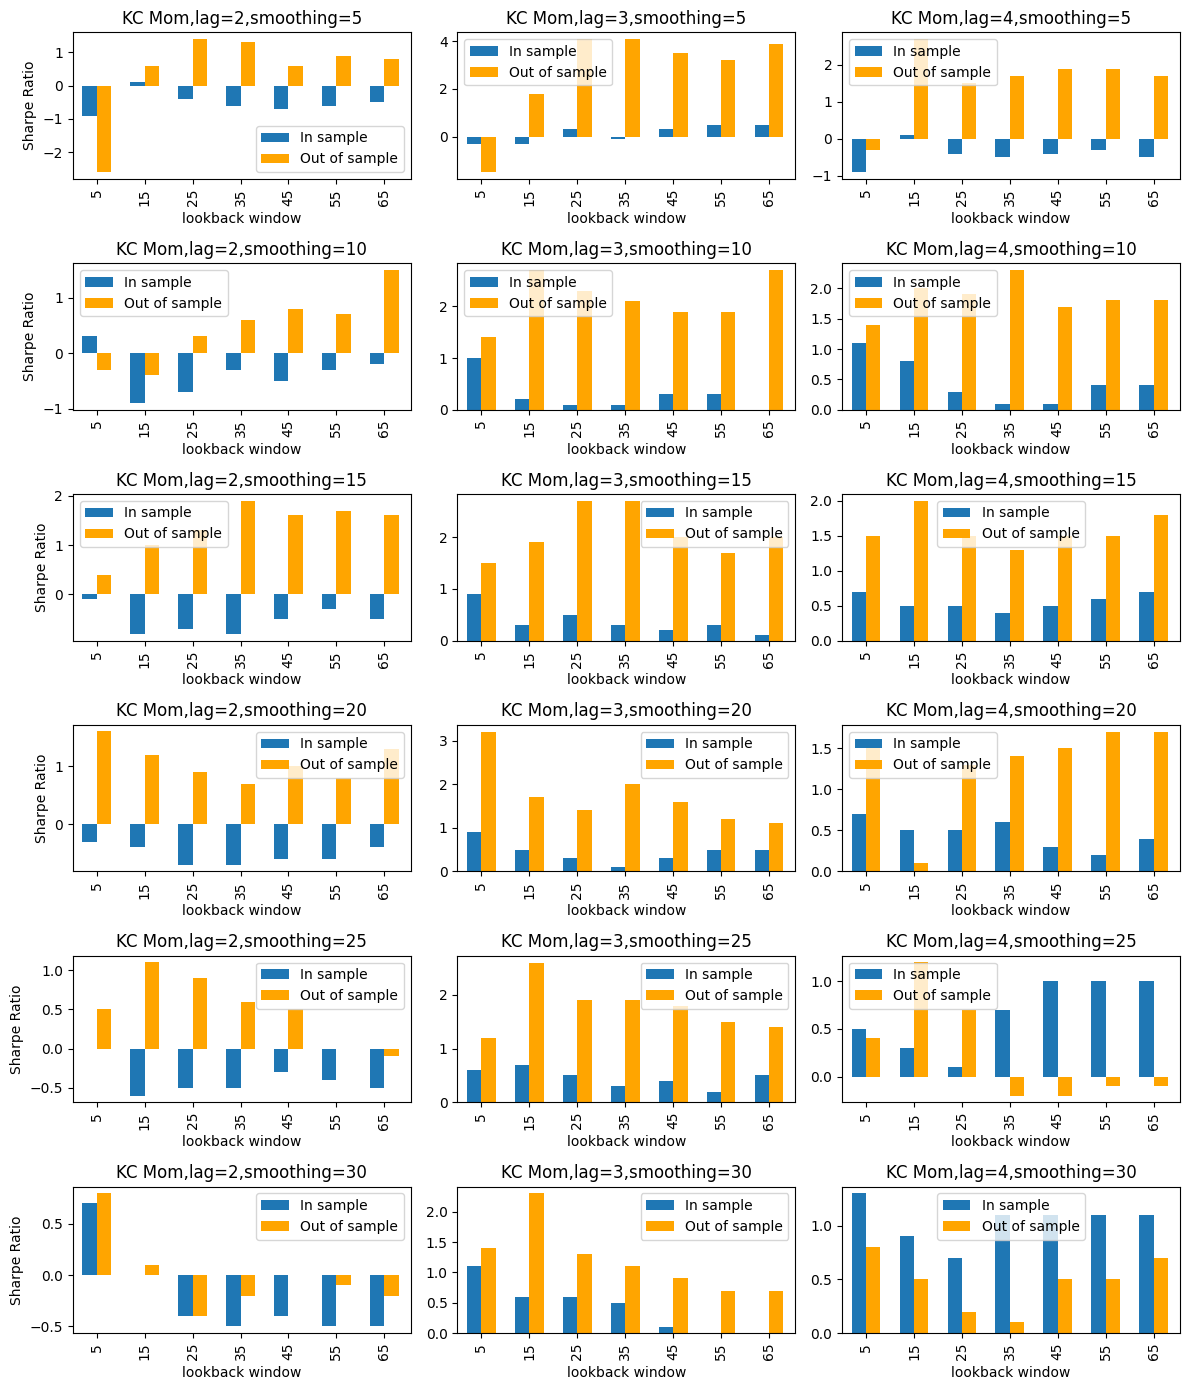

In [ ]:
robust_attribute_dict ={
    'y':'Sharpe Ratio', # could be changed to max drawdown, sortino ratio, etc
    'x':'lookback window',
    'row':'lag',
    'col':'smoothing'
}

# Check that you are passing correct insample and out of sample dataframes
# Attribute dict argument is unchanged unless you'd like to plot max drawdown,etc

### UPDATE the label below to your strategy

plot_robustness(kc_mom_ins,kc_mom_oos,robust_attribute_dict,label='KC Mom')

## 3.4 MACD

In [ ]:
macd, macd_calc, macd_signal = st.macd_signal(data_ins.copy(),
                                              window_slow=26,window_fast=12)

In [ ]:
# macd.dropna().plot(figsize=(12,5),title='MACD')
# macd_calc.dropna().plot(figsize=(12,5),title='MACD signal')
# macd_signal.dropna().plot(figsize=(12,5),title='MACD histogram')

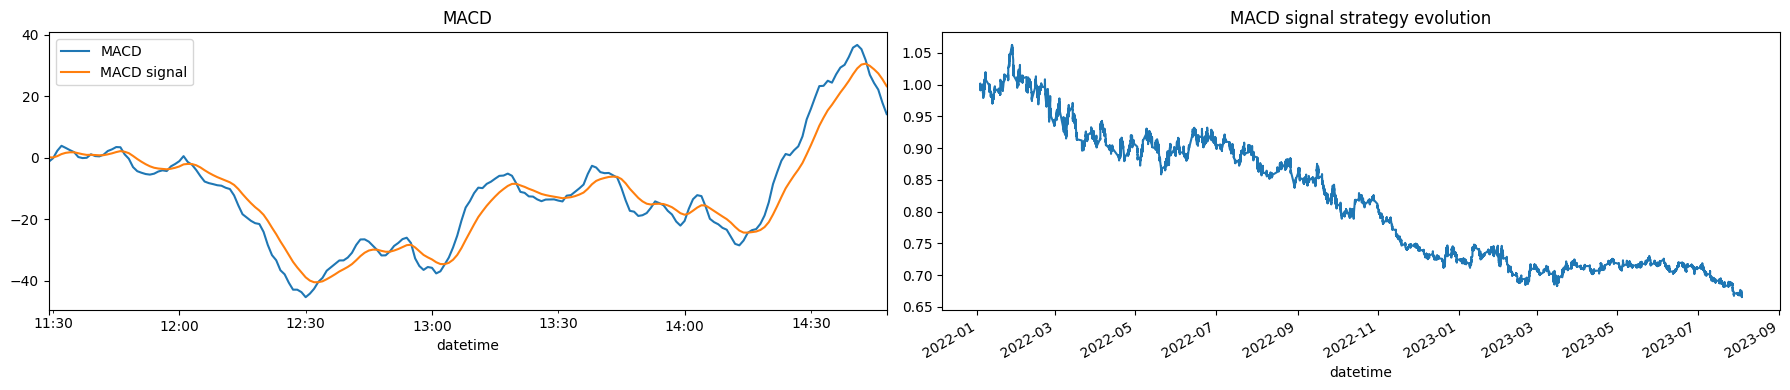

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,4))

pd.DataFrame({'MACD':macd,
              'MACD signal':macd_calc,
              # 'Close':data_ins['close'],
              },index=data_ins.index).tail(200).plot(ax=ax[0],
                                                     title='MACD')

(1+pd.Series(macd_signal,index=data_ins.index).shift(1)*data_ins['return']
 ).cumprod().plot(ax=ax[1],title='MACD signal strategy evolution')

# (1+pd.Series(bb_sig_cont,index=bank_nifty_f1.index).shift(1)*bank_nifty_f1['return']).cumprod().plot(ax=ax[2],title='Bollinger Bands continuous strategy evolution')

plt.tight_layout()
plt.show()

In [ ]:
def test_robustness(data,indicator,multiplier,window_slow,window_fast,lags):
    if multiplier not in (1, -1):
        raise ValueError("Multiplier must be either 1 or -1")
    results = []
    ts = {'signal': {}, 'strategy_returns': {}, 'cumulative_returns': {}}
    count_bands = len(np.arange(window_slow['start'],window_slow['end']+window_slow['step'],
                    window_slow['step']))
    fig,ax = plt.subplots(1,count_bands,figsize=(18,4))
    for i,w_slow in enumerate(np.arange(window_slow['start'],window_slow['end']+window_slow['step'],
                          window_slow['step'])):
        legend = []
        # smooth = smooth.round(1) if isinstance(smooth, float) else smooth
        # print(i)
        for w_fast in range(window_fast['start'],
                            window_fast['end']+window_fast['step'],
                            window_fast['step']):
            if w_fast >= w_slow:
                continue
            else:
                _, _, signal = st.macd_signal(data,
                                              window_slow=w_slow,window_fast=w_fast)

                (1+pd.Series(signal,index=data[-len(signal):].index).shift(1)*data['return'][-len(signal):]).cumprod().plot(
                    title=f'{indicator} strategy,fast={w_fast},slow={w_slow},no lag',ax=ax[i])
                legend.append(f'fast={w_fast},slow={w_slow}')
                for lag in range(lags['start'],lags['end']+lags['step'],lags['step']):
                    key = f's{w_slow}f{w_fast}l{lag}'
                    data[f'{key}_signal'] = pd.Series(signal,
                                              index=data[-len(signal):].index
                                              ).shift(lag).fillna(0)
                    strategy_returns = multiplier * data[f'{key}_signal'] * data['return'][-len(signal):]
                    # m = 252*6.25*60
                    # print(strategy_returns.std())
                    # Identify the start and end of holding periods
                    data['holding'] = pd.Series(
                        signal,index=data[-len(signal):].index
                        ).shift(lag).diff().fillna(0).abs()
                    data['holding'] = data['holding'].cumsum()
                    # Calculate the duration of each holding period
                    holding_periods = data[data[f'{key}_signal'] != 0].groupby('holding').size()
                    # Check if holding_periods is empty, and if so, set holding_period to NaN
                    # Otherwise calculate and round as before
                    if holding_periods.empty:
                        holding_period = np.nan  # Use float('nan') for consistency
                    else:
                        holding_period = holding_periods.mean().round(1)

                    analytics = st.calculate_analytics(strategy_returns)
                    results.append({
                        'Indicator': indicator,
                        'Strategy': 'Momentum' if multiplier==1 else 'Mean reversion',
                        'Slow window': w_slow,
                        'Fast window': w_fast,
                        'lag': lag,
                        'holding period': holding_period,
                        **analytics
                    })

                    ts['signal'][key] = data[f'{key}_signal'].to_frame(key)
                    ts['strategy_returns'][key] = strategy_returns.to_frame(key)
                    ts['cumulative_returns'][key] = (1+strategy_returns).cumprod().to_frame(key)

        ax[i-1].legend(legend,loc='upper left')
        if i==1:
            ax[i-1].set_ylabel('Cumulative return')
    plt.tight_layout()
    plt.show()

    analytics = pd.DataFrame(results).fillna(0)
    display(analytics)
    return analytics,ts

In [ ]:
slow_window = {'start':10,
                   'step':10,
                   'end':60}# exclusive
fast_window = {'start':5,
                  'step':10,
                  'end':60}#inclusive
lags = {'start':2, #Shift the signal by 2 or more for realistic implementation
        'step':1,
        'end':4}#inclusive

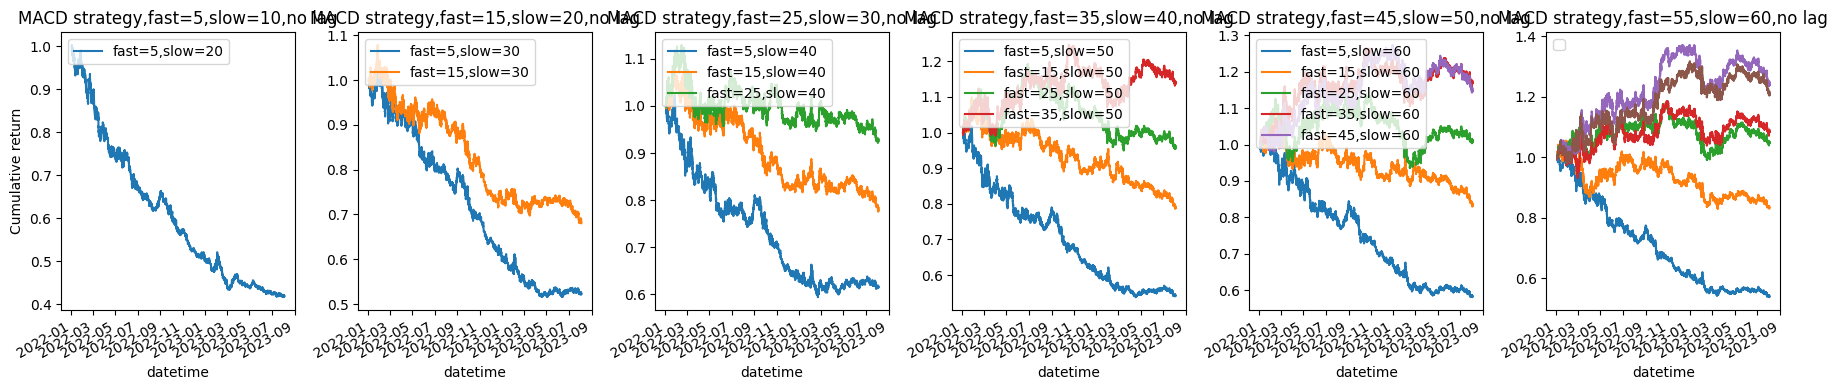

Indicator  Strategy  Slow window  Fast window  lag  holding period  \
0       MACD  Momentum           10            5    2             7.0   
1       MACD  Momentum           10            5    3             7.0   
2       MACD  Momentum           10            5    4             7.0   
3       MACD  Momentum           20            5    2             8.3   
4       MACD  Momentum           20            5    3             8.3   
..       ...       ...          ...          ...  ...             ...   
58      MACD  Momentum           60           45    3            25.0   
59      MACD  Momentum           60           45    4            25.0   
60      MACD  Momentum           60           55    2            27.2   
61      MACD  Momentum           60           55    3            27.2   
62      MACD  Momentum           60           55    4            27.2   

    Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0           -2.3           -2.7      0.730660 -0.000747   
1           -1.0           -1.2      0.425410 -0.000745   
2           -1.0           -1.3      0.501448 -0.000748   
3           -1.0           -1.3      0.415034 -0.000744   
4           -0.5           -0.7      0.323931 -0.000741   
..           ...            ...           ...       ...   
58           1.4            1.8      0.039309 -0.000735   
59           1.3            1.6      0.099464 -0.000735   
60           1.0            1.3      0.034127 -0.000735   
61           1.2            1.4      0.098296 -0.000734   
62           0.8            0.9      0.112792 -0.000734   

    Expected shortfall(95%)  Ann. return  Ann. vol  
0                 -0.001248       -0.402     0.186  
1                 -0.001244       -0.159     0.186  
2                 -0.001246       -0.175     0.186  
3                 -0.001232       -0.168     0.186  
4                 -0.001235       -0.082     0.186  
..                      ...          ...       ...  
58                -0.001226        0.289     0.186  
59                -0.001228        0.257     0.186  
60                -0.001228        0.211     0.186  
61                -0.001232        0.239     0.186  
62                -0.001238        0.162     0.186  

[63 rows x 13 columns]

In [ ]:
macd_mom_ins,macd_mom_ts_ins = test_robustness(
    data_ins.copy(),indicator='MACD',multiplier=1,
    window_slow=slow_window,window_fast=fast_window,lags=lags)

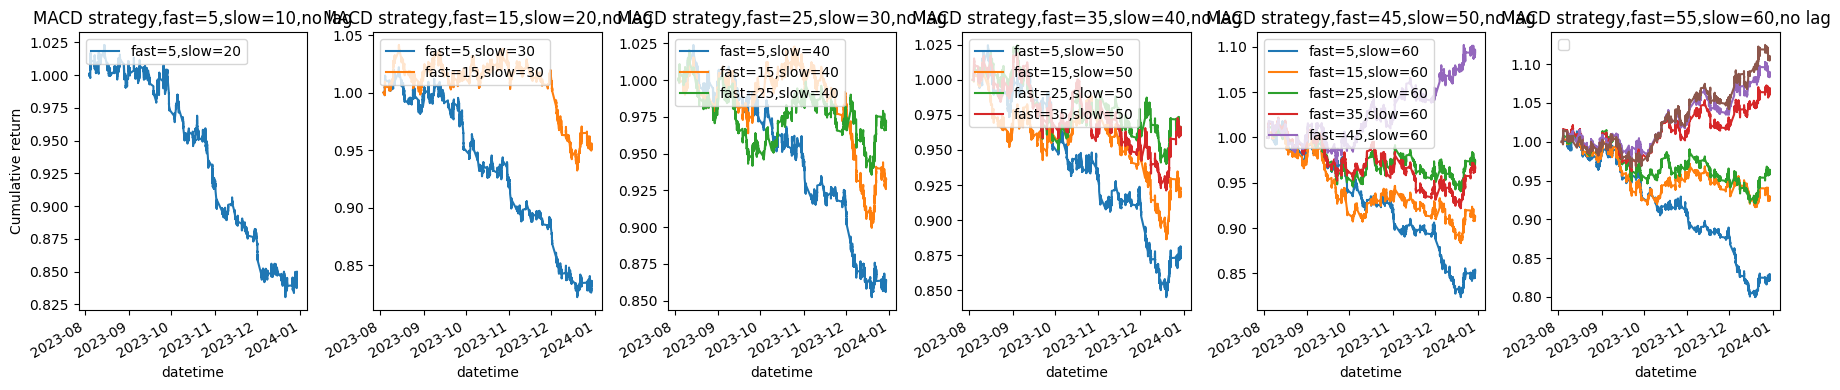

Indicator  Strategy  Slow window  Fast window  lag  holding period  \
0       MACD  Momentum           10            5    2             7.0   
1       MACD  Momentum           10            5    3             7.0   
2       MACD  Momentum           10            5    4             7.0   
3       MACD  Momentum           20            5    2             8.2   
4       MACD  Momentum           20            5    3             8.2   
..       ...       ...          ...          ...  ...             ...   
58      MACD  Momentum           60           45    3            24.5   
59      MACD  Momentum           60           45    4            24.5   
60      MACD  Momentum           60           55    2            27.1   
61      MACD  Momentum           60           55    3            27.1   
62      MACD  Momentum           60           55    4            27.1   

    Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
0           -2.8           -3.3      0.166952 -0.000484   
1           -2.9           -3.4      0.168999 -0.000484   
2           -1.8           -2.3      0.126433 -0.000483   
3           -1.9           -2.4      0.118359 -0.000482   
4           -1.1           -1.3      0.095823 -0.000480   
..           ...            ...           ...       ...   
58           1.9            2.6      0.038568 -0.000475   
59           2.0            2.7      0.037604 -0.000476   
60           1.8            2.4      0.063958 -0.000474   
61           1.8            2.4      0.046920 -0.000475   
62           1.9            2.6      0.053465 -0.000476   

    Expected shortfall(95%)  Ann. return  Ann. vol  
0                 -0.000818       -0.318     0.121  
1                 -0.000826       -0.334     0.121  
2                 -0.000816       -0.201     0.121  
3                 -0.000807       -0.211     0.121  
4                 -0.000809       -0.110     0.121  
..                      ...          ...       ...  
58                -0.000777        0.248     0.121  
59                -0.000781        0.261     0.121  
60                -0.000776        0.232     0.121  
61                -0.000780        0.238     0.121  
62                -0.000780        0.252     0.121  

[63 rows x 13 columns]

In [ ]:
macd_mom_oos,macd_mom_ts_oos = test_robustness(
    data_oos.copy(),indicator='MACD',multiplier=1,
    window_slow=slow_window,window_fast=fast_window,lags=lags)

In [ ]:
macd_mom_oos.loc[macd_mom_oos['Sharpe Ratio']>1.4]

Indicator  Strategy  Slow window  Fast window  lag  holding period  \
44      MACD  Momentum           50           45    4            23.5   
55      MACD  Momentum           60           35    3            22.3   
56      MACD  Momentum           60           35    4            22.3   
57      MACD  Momentum           60           45    2            24.5   
58      MACD  Momentum           60           45    3            24.5   
59      MACD  Momentum           60           45    4            24.5   
60      MACD  Momentum           60           55    2            27.1   
61      MACD  Momentum           60           55    3            27.1   
62      MACD  Momentum           60           55    4            27.1   

    Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
44           1.9            2.5      0.039556 -0.000477   
55           1.8            2.3      0.037515 -0.000475   
56           1.5            1.9      0.036626 -0.000478   
57           1.7            2.3      0.043187 -0.000475   
58           1.9            2.6      0.038568 -0.000475   
59           2.0            2.7      0.037604 -0.000476   
60           1.8            2.4      0.063958 -0.000474   
61           1.8            2.4      0.046920 -0.000475   
62           1.9            2.6      0.053465 -0.000476   

    Expected shortfall(95%)  Ann. return  Ann. vol  
44                -0.000784        0.250     0.121  
55                -0.000784        0.233     0.121  
56                -0.000787        0.196     0.121  
57                -0.000775        0.227     0.121  
58                -0.000777        0.248     0.121  
59                -0.000781        0.261     0.121  
60                -0.000776        0.232     0.121  
61                -0.000780        0.238     0.121  
62                -0.000780        0.252     0.121

In [ ]:
macd_mom_ins.loc[macd_mom_ins['Sharpe Ratio']>1.4]

Indicator  Strategy  Slow window  Fast window  lag  holding period  \
41      MACD  Momentum           50           35    4            21.6   
43      MACD  Momentum           50           45    3            23.6   
44      MACD  Momentum           50           45    4            23.6   
55      MACD  Momentum           60           35    3            22.7   
56      MACD  Momentum           60           35    4            22.7   

    Sharpe Ratio  Sortino Ratio  Max Drawdown  VaR(95%)  \
41           1.5            2.0      0.037362 -0.000737   
43           1.5            2.0      0.013961 -0.000735   
44           1.7            2.2      0.057445 -0.000735   
55           1.6            2.0      0.013173 -0.000735   
56           1.7            2.2      0.046579 -0.000736   

    Expected shortfall(95%)  Ann. return  Ann. vol  
41                -0.001222        0.308     0.186  
43                -0.001222        0.306     0.186  
44                -0.001221        0.343     0.186  
55                -0.001219        0.317     0.186  
56                -0.001221        0.338     0.186

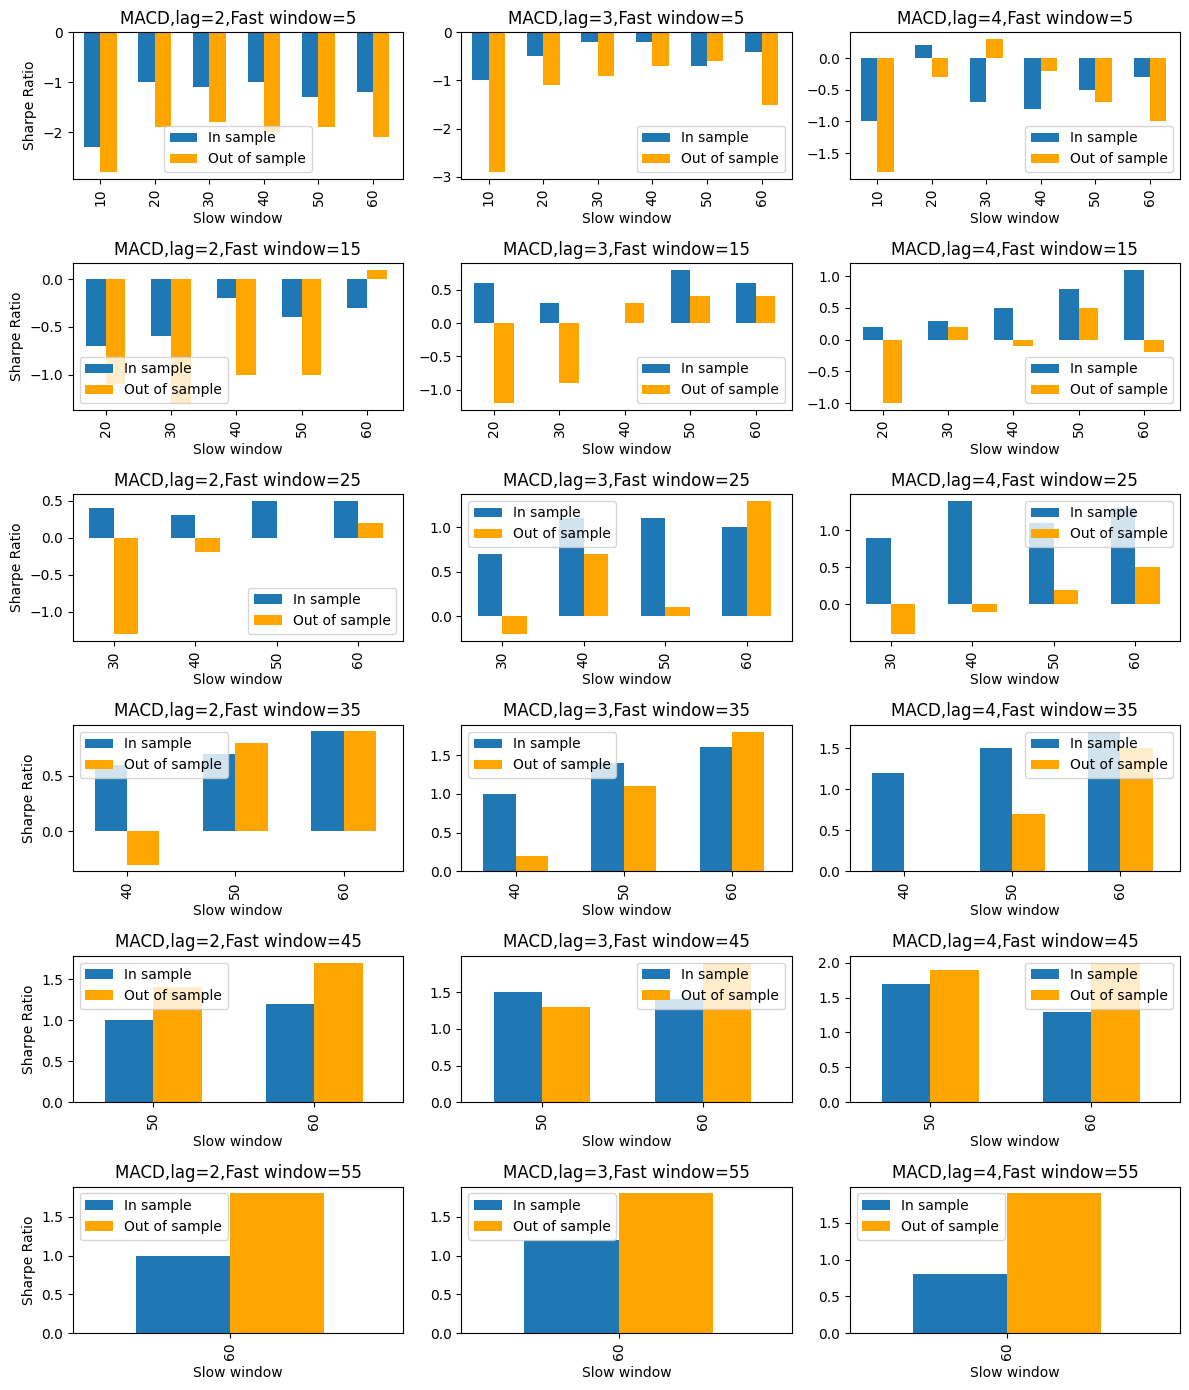

In [ ]:
robust_attribute_dict ={
    'y':'Sharpe Ratio', # could be changed to max drawdown, sortino ratio, etc
    'x':'Slow window',
    'row':'lag',
    'col':'Fast window'
}

# Check that you are passing correct insample and out of sample dataframes
# Attribute dict argument is unchanged unless you'd like to plot max drawdown,etc

### UPDATE the label below to your strategy

plot_robustness(macd_mom_ins,macd_mom_oos,robust_attribute_dict,label='MACD')

In [ ]:
pd.concat([macd_mom_ts_ins['signal']['s60f35l4'],
           macd_mom_ts_oos['signal']['s60f35l4']],
          axis=0).to_csv('/content/trading_signals_MACD_mom.csv')

In [ ]:
# pd.concat([
#            pd.read_csv(f'/content/{repo_name}/Signals/trading_signals_MACD_mom.csv',index_col=0),
#            pd.read_csv(f'/content/{repo_name}/Signals/trading_signals_ATR_rev.csv',index_col=0),
#            pd.read_csv(f'/content/{repo_name}/Signals/trading_signals_Bollinger_bands_mr.csv',index_col=0),
#            pd.read_csv(f'/content/{repo_name}/Signals/trading_signals_Bollinger_bands_mom.csv',index_col=0),
#            ],axis=1).head()
pd.concat([
           pd.read_csv(f'/content/{repo_name}/Signals/data_ins_all_signals.csv'),
           pd.read_csv(f'/content/{repo_name}/Signals/data_oos_all_signals.csv'),
          #  pd.read_csv(f'/content/{repo_name}/Signals/trading_signals_Bollinger_bands_mr.csv',index_col=0),
          #  pd.read_csv(f'/content/{repo_name}/Signals/trading_signals_Bollinger_bands_mom.csv',index_col=0),
           ],axis=1).head()

ticker      open      high       low     close  volume       OI  \
0  BANKNIFTY_F1  36621.00  36621.00  35708.05  35811.85   82603  2347925   
1  BANKNIFTY_F1  35813.95  35825.75  35798.70  35798.70   38900  2347925   
2  BANKNIFTY_F1  35796.55  35796.90  35757.40  35782.60   28775  2368975   
3  BANKNIFTY_F1  35782.60  35834.25  35782.60  35834.25   28900  2368975   
4  BANKNIFTY_F1  35830.50  35839.65  35823.40  35835.00   28275  2368975   

     return  signal_FE  signal_CCI  ...        open        high         low  \
0  0.000000          0           0  ...  44642.5508  44645.6992  44611.0000   
1 -0.000367          0           0  ...  44623.6484  44624.6992  44583.0000   
2 -0.000450          1           0  ...  44598.5000  44617.5508  44587.1016   
3  0.001442         -1           0  ...  44599.0000  44616.9492  44597.6484   
4  0.000021         -1           0  ...  44610.1016  44617.5508  44596.6016   

        close   volume         OI    return  signal_FE  signal_CCI  signal_CMF  
0  44620.6016  11130.0  1943355.0 -0.000402        0.0         0.0         0.0  
1  44594.1992   9990.0  1943355.0 -0.000592        0.0         0.0         0.0  
2  44596.6992   6345.0  1948140.0  0.000056        1.0         0.0         0.0  
3  44606.8516   8775.0  1948140.0  0.000228       -1.0         0.0         0.0  
4  44596.6016   7290.0  1948140.0 -0.000230       -1.0         0.0         1.0  

[5 rows x 22 columns]

# Full list of indicators

1. Bollinger Bands (Upper/Lower crossing)
2. Z-Score of the price relative to moving average
3. RSI (Relative Strength Index) below 30 (oversold)
4. Williams %R (Overbought/oversold)
5. Commodity Channel Index (CCI) crossing threshold
6. Moving Average Convergence Divergence (MACD)
7. Price crossing VWAP (Volume-Weighted Average Price)
8. Price Distance from Exponential Moving Average (EMA)
9. Price Distance from Simple Moving Average (SMA)
10. Chaikin Money Flow crossing zero
11. Price-Volume Trend (PVT)
12. Volume Spike Reversion
13. ATR Bands crossing (Average True Range)
14. Donchian Channel Reversion
15. Price Relative to Keltner Channel
16. Price crossing Ichimoku Cloud baseline
17. Money Flow Index (MFI) reversion
18. On-Balance Volume (OBV) Divergence
19. Parabolic SAR Reversion
20. Force Index Reversion
21. Stochastic Oscillator (Crossing 20/80 levels)
22. Directional Movement Index (DMI) Cross
23. Chande Momentum Oscillator (CMO) crossing thresholds
24. Intraday Volume Weighted Moving Average
25. Intraday Price Spike Reversion

In [16]:
xs_close_df = pd.DataFrame()
xs_ret_df = pd.DataFrame()

for tkr in equity_tickers:
    print(tkr)
    xs_close_df = pd.concat(
        [xs_close_df,
         td.load_minutely_data(ticker=tkr,filter='F1')['close'].rename(tkr)
        ],axis=1)
    xs_ret_df = pd.concat(
        [xs_ret_df,
         td.load_minutely_data(ticker=tkr,filter='F1')['return'].rename(tkr)
        ],axis=1)

xs_close_df = xs_close_df.sort_index()
xs_ret_df = xs_ret_df.sort_index()
xs_close_df.head()

Streaming output truncated to the last 5000 lines.
Reading CSV file: /content/capstone/Data/Futures IEOD-January 2022/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-June 2023/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-August 2022/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-November 2023/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-September 2022/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-August 2023/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-January 2023/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-February 2022/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-February 2023/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-July 2022/HEROMOTOCO_F1.csv
Reading CSV file: /content/capstone/Data/Futures IEOD-July 2023/HEROMOTOCO_F1.csv
Reading CSV file: /c

AARTIIND  ABB  ABBOTINDIA  ABCAPITAL   ABFRL     ACC  \
2022-01-03 09:15:00   1017.90  NaN         NaN     125.05  273.55  2234.0   
2022-01-03 09:16:00   1018.00  NaN         NaN     125.05  272.60  2235.0   
2022-01-03 09:17:00   1016.65  NaN         NaN     124.95  271.10  2231.6   
2022-01-03 09:18:00   1021.10  NaN         NaN     125.25  271.75  2231.0   
2022-01-03 09:19:00   1022.00  NaN    19669.55     125.30     NaN  2232.0   

                     ADANIENT  ADANIPORTS    ALKEM  AMBUJACEM  ...    TRENT  \
2022-01-03 09:15:00   1729.20      734.70      NaN     380.75  ...  1058.60   
2022-01-03 09:16:00   1726.05      736.45      NaN     380.80  ...  1057.00   
2022-01-03 09:17:00   1722.65      734.10  3659.90     380.25  ...  1064.70   
2022-01-03 09:18:00   1725.00      737.15  3637.25     380.50  ...      NaN   
2022-01-03 09:19:00   1726.50      737.05  3649.95     380.90  ...  1059.55   

                     TVSMOTOR      UBL  ULTRACEMCO     UPL    VEDL   VOLTAS  \
2022-01-03 09:15:00    628.10  1582.15     7634.45  753.00  343.25  1232.00   
2022-01-03 09:16:00    630.65  1581.00     7639.85  754.85  343.45  1233.80   
2022-01-03 09:17:00    629.85  1578.00     7638.00  752.60  342.65  1236.00   
2022-01-03 09:18:00    627.60  1573.95     7610.00  753.60  342.90  1237.55   
2022-01-03 09:19:00    627.75  1572.35     7609.15  754.65  344.00  1236.35   

                      WIPRO    ZEEL  ZYDUSLIFE  
2022-01-03 09:15:00  720.65  322.00        NaN  
2022-01-03 09:16:00  724.70  322.65        NaN  
2022-01-03 09:17:00  725.10  322.65        NaN  
2022-01-03 09:18:00  726.00  323.50        NaN  
2022-01-03 09:19:00  726.35  323.40        NaN  

[5 rows x 182 columns]

In [17]:
size_insample = int(0.8*len(xs_close_df))
xs_close_ins = xs_close_df[:size_insample]
xs_close_oos = xs_close_df[size_insample:]
size_insample = int(0.8*len(xs_ret_df))
xs_ret_ins = xs_ret_df[:size_insample]
xs_ret_oos = xs_ret_df[size_insample:]

In [16]:
offset = 0
lookback_period = 20
momentum  = xs_close_df.shift(offset) / xs_close_df.shift(
    lookback_period+offset) -1

momentum.tail()
# equity_xs_df.tail()

AARTIIND       ABB  ABBOTINDIA  ABCAPITAL     ABFRL  \
2023-12-29 15:26:00 -0.000305 -0.000287    0.001513  -0.002976 -0.000221   
2023-12-29 15:27:00 -0.002133 -0.000807    0.001093  -0.006228  0.000221   
2023-12-29 15:28:00 -0.000915 -0.000987    0.001952  -0.004455 -0.000443   
2023-12-29 15:29:00 -0.001144 -0.002311    0.000356  -0.004162  0.000664   
2023-12-29 15:30:00       NaN       NaN         NaN        NaN       NaN   

                          ACC  ADANIENT  ADANIPORTS     ALKEM  AMBUJACEM  ...  \
2023-12-29 15:26:00 -0.001954 -0.001042   -0.002851 -0.001799  -0.001803  ...   
2023-12-29 15:27:00 -0.002963 -0.000937   -0.001933 -0.001091  -0.002089  ...   
2023-12-29 15:28:00 -0.003502  0.000695   -0.000484  0.000335  -0.003324  ...   
2023-12-29 15:29:00 -0.003188  0.001391    0.000242  0.001303  -0.001426  ...   
2023-12-29 15:30:00       NaN       NaN         NaN       NaN        NaN  ...   

                        TRENT  TVSMOTOR       UBL  ULTRACEMCO       UPL  \
2023-12-29 15:26:00 -0.001573 -0.000538 -0.002553    0.001233 -0.001686   
2023-12-29 15:27:00 -0.002253  0.000489  0.000139   -0.000052 -0.002274   
2023-12-29 15:28:00 -0.001590  0.000318 -0.000278    0.000191 -0.002022   
2023-12-29 15:29:00 -0.000957  0.001199 -0.000417   -0.000668 -0.000927   
2023-12-29 15:30:00       NaN       NaN       NaN         NaN -0.001096   

                         VEDL    VOLTAS     WIPRO      ZEEL  ZYDUSLIFE  
2023-12-29 15:26:00 -0.003827 -0.001214 -0.002110 -0.003236  -0.000287  
2023-12-29 15:27:00 -0.004781 -0.000506 -0.002320 -0.003235   0.000359  
2023-12-29 15:28:00 -0.004400  0.000253 -0.002743 -0.003596  -0.000072  
2023-12-29 15:29:00 -0.002871  0.000557 -0.001899 -0.001080   0.000791  
2023-12-29 15:30:00       NaN       NaN       NaN       NaN        NaN  

[5 rows x 182 columns]

In [17]:
xs_mom = exp.xscore(momentum)
xs_mom = xs_mom.clip(-3,3)
xs_mom = xs_mom.dropna(how='all')
# xs_mom.head()
xs_mom.tail()

AARTIIND       ABB  ABBOTINDIA  ABCAPITAL     ABFRL  \
2023-12-29 15:26:00  0.614572  0.623572    1.501528  -0.688149  0.655465   
2023-12-29 15:27:00 -0.295980  0.293914    1.138997  -2.117541  0.751244   
2023-12-29 15:28:00  0.174309  0.144274    1.371794  -1.304237  0.371642   
2023-12-29 15:29:00 -0.018854 -0.491984    0.588592  -1.241749  0.713593   
2023-12-29 15:30:00       NaN       NaN         NaN        NaN       NaN   

                          ACC  ADANIENT  ADANIPORTS     ALKEM  AMBUJACEM  ...  \
2023-12-29 15:26:00 -0.189374  0.255166   -0.627259 -0.113790  -0.116130  ...   
2023-12-29 15:27:00 -0.665206  0.235884   -0.207007  0.167466  -0.276418  ...   
2023-12-29 15:28:00 -0.906380  0.846898    0.354487  0.696548  -0.832032  ...   
2023-12-29 15:29:00 -0.847320  1.008071    0.542540  0.972522  -0.133456  ...   
2023-12-29 15:30:00       NaN       NaN         NaN       NaN        NaN  ...   

                        TRENT  TVSMOTOR       UBL  ULTRACEMCO       UPL  \
2023-12-29 15:26:00 -0.003874  0.501010 -0.481891    1.364551 -0.058720   
2023-12-29 15:27:00 -0.349372  0.870405  0.714687    0.629438 -0.358800   
2023-12-29 15:28:00 -0.107481  0.689360  0.440413    0.636283 -0.287832   
2023-12-29 15:29:00  0.056745  0.930222  0.275501    0.173650  0.068787   
2023-12-29 15:30:00       NaN       NaN       NaN         NaN  0.141896   

                         VEDL    VOLTAS     WIPRO      ZEEL  ZYDUSLIFE  
2023-12-29 15:26:00 -1.103113  0.171471 -0.265549 -0.814983   0.623192  
2023-12-29 15:27:00 -1.473985  0.427894 -0.379315 -0.786293   0.812626  
2023-12-29 15:28:00 -1.281358  0.662228 -0.589003 -0.945644   0.526531  
2023-12-29 15:29:00 -0.718926  0.670171 -0.325081  0.006774   0.764929  
2023-12-29 15:30:00       NaN       NaN       NaN       NaN        NaN  

[5 rows x 182 columns]

In [18]:
# prompt: how to divide xs_mom by sum of each row to normalize

xs_mom_normalized = xs_mom.div(xs_mom.abs().sum(axis=1), axis=0)
xs_mom_normalized.head()

AARTIIND  ABB  ABBOTINDIA  ABCAPITAL     ABFRL       ACC  \
2022-01-03 09:35:00 -0.012676  NaN         NaN   0.008306 -0.007689 -0.005319   
2022-01-03 09:36:00 -0.012252  NaN         NaN   0.005498       NaN -0.004262   
2022-01-03 09:37:00       NaN  NaN         NaN   0.005379  0.006064 -0.002318   
2022-01-03 09:38:00       NaN  NaN         NaN   0.002527  0.006207 -0.002686   
2022-01-03 09:39:00 -0.019258  NaN         NaN        NaN       NaN -0.001547   

                     ADANIENT  ADANIPORTS     ALKEM  AMBUJACEM  ...     TRENT  \
2022-01-03 09:35:00 -0.001399    0.006634       NaN  -0.000970  ...  0.003350   
2022-01-03 09:36:00  0.001293    0.004461       NaN   0.000195  ...  0.004008   
2022-01-03 09:37:00  0.002589    0.008063 -0.002233   0.001956  ...       NaN   
2022-01-03 09:38:00 -0.000133    0.002410  0.005010   0.001335  ...       NaN   
2022-01-03 09:39:00 -0.000154    0.003804       NaN  -0.000461  ...  0.001013   

                     TVSMOTOR       UBL  ULTRACEMCO       UPL      VEDL  \
2022-01-03 09:35:00 -0.018362       NaN   -0.005603       NaN  0.004428   
2022-01-03 09:36:00 -0.027751 -0.004389   -0.004075  0.001384  0.005224   
2022-01-03 09:37:00 -0.029378       NaN   -0.005114  0.002877  0.007194   
2022-01-03 09:38:00 -0.029893  0.000735    0.001307  0.001171  0.005237   
2022-01-03 09:39:00 -0.031177  0.002977    0.004812  0.000758  0.004470   

                       VOLTAS     WIPRO      ZEEL  ZYDUSLIFE  
2022-01-03 09:35:00 -0.002511  0.011090  0.009783        NaN  
2022-01-03 09:36:00 -0.004529  0.003464  0.007130        NaN  
2022-01-03 09:37:00 -0.007948  0.002586  0.006086        NaN  
2022-01-03 09:38:00 -0.010292  0.001174  0.004300        NaN  
2022-01-03 09:39:00 -0.009331  0.000400  0.005282        NaN  

[5 rows x 182 columns]

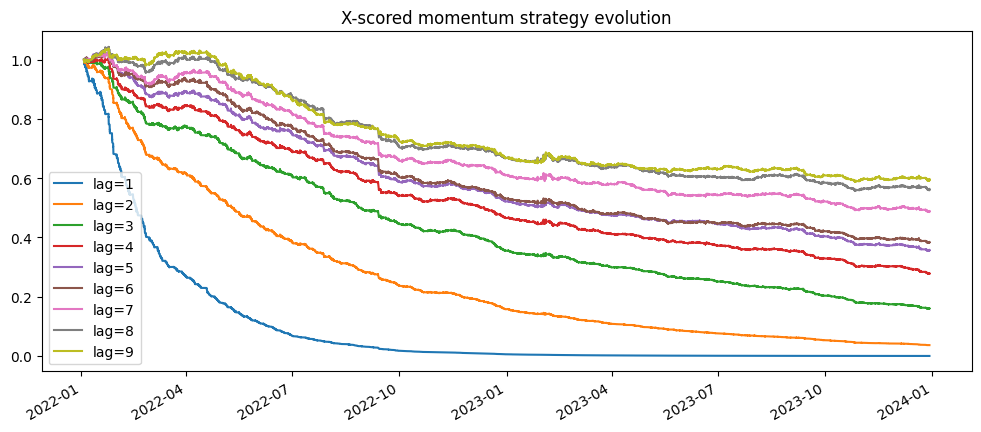

In [19]:
plt.figure(figsize=(12,5))
plt.title('X-scored momentum strategy evolution')
for lag in range(1,10):
    (1+xs_mom_normalized.shift(lag).mul(
        xs_ret_df.reindex(xs_mom_normalized.index)).sum(axis=1)).cumprod().plot(
            label=f'lag={lag}'
        )
plt.legend()
plt.show()
# display(xs_mom_normalized.max().max())
# display(xs_mom_normalized.min().min())

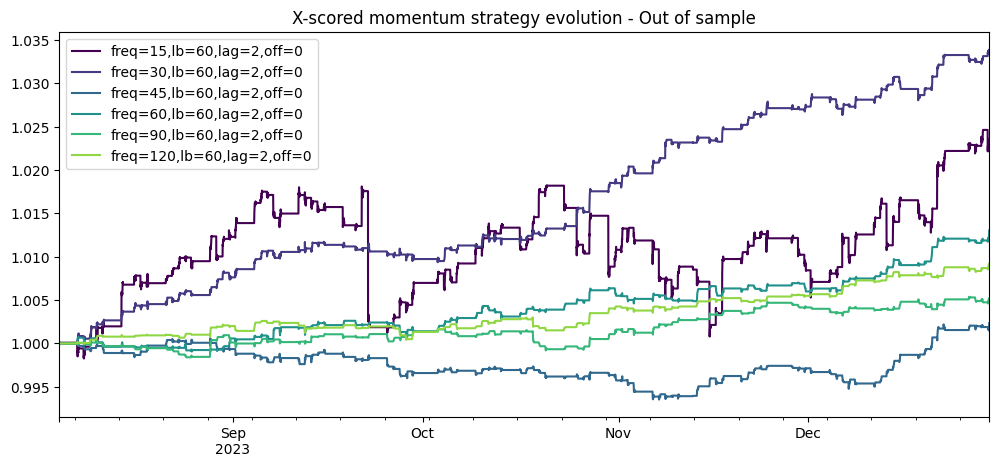

In [47]:
plt.figure(figsize=(12,5))
plt.title('X-scored momentum strategy evolution - Out of sample')
i=0
# rebal_freq_list = [15,30,60,120]
rebal_freq_list = [15,30,45,60,90,120]
offset_list = [0]
# lookback_list = [60,120,240,360]
lookback_list = [60]
lag_list = list(range(2,3))
number_of_series = len(offset_list)*len(lookback_list)*len(lag_list)*len(rebal_freq_list)
# Generate a colormap
colormap = plt.cm.viridis
colors = [colormap(i / number_of_series) for i in range(number_of_series)]


for offset in offset_list:

    for lookback in lookback_list:

        momentum  = xs_close_oos.shift(offset) / xs_close_oos.shift(
            lookback+offset) -1

        xs_mom = exp.xscore(momentum)
        xs_mom = xs_mom.clip(-3,3)
        xs_mom = xs_mom.dropna(how='all')
        xs_mom_normalized = xs_mom.div(xs_mom.abs().sum(axis=1), axis=0)
        xs_mom_normalized.index = pd.to_datetime(xs_mom_normalized.index)

        for freq in rebal_freq_list:
            df_filled = xs_mom_normalized.resample(f'{freq}T').ffill()

            for lag in lag_list:
                (1+df_filled.shift(lag).mul(
                    xs_ret_oos.reindex(df_filled.index)).sum(axis=1)).cumprod().plot(
                        color=colors[i],
                        label=f'freq={freq},lb={lookback},lag={lag},off={offset}'
                    )
                i+=1
plt.legend()
plt.show()

In [85]:
i=0
rebal_freq_list = [15,30,45,60,90,120]
offset_list = [0,15,30]
# offset_list = [0]
lookback_list = [60,120,240,360]

lag_list = list(range(2,4))
number_of_series = len(offset_list)*len(lookback_list)*len(lag_list)*len(rebal_freq_list)
# Generate a colormap
colormap = plt.cm.viridis
colors = [colormap(i / number_of_series) for i in range(number_of_series)]
results = []
for offset in offset_list:

    for lookback in lookback_list:

        momentum  = xs_close_ins.shift(offset) / xs_close_ins.shift(
            lookback+offset) -1

        xs_mom = exp.xscore(momentum)
        xs_mom = xs_mom.clip(-3,3)
        xs_mom = xs_mom.dropna(how='all')
        xs_mom_normalized = xs_mom.div(xs_mom.abs().sum(axis=1), axis=0)
        xs_mom_normalized.index = pd.to_datetime(xs_mom_normalized.index)

        for freq in rebal_freq_list:
            df_filled = xs_mom_normalized.resample(f'{freq}T').ffill()

            for lag in lag_list:
                # multiplier = -1 if offset==0 else 1
                multiplier = -1
                strategy_returns = df_filled.shift(lag).mul(
                    xs_ret_ins.reindex(df_filled.index)).sum(axis=1)
                strategy_returns = multiplier * strategy_returns


                # (1+xs_mom_normalized.shift(lag).mul(
                #     xs_ret_ins.reindex(xs_mom_normalized.index)).sum(axis=1)).cumprod().plot(
                #         color=colors[i],
                #         label=f'lb={lookback},lag={lag},off={offset}'
                #     )
                i+=1
                # print(strategy_returns.index.dtype)
                strategy_returns.index = pd.to_datetime(strategy_returns.index)
                # print(((1+strategy_returns).cumprod()-1)[-1])
                analytics = st.calculate_analytics(strategy_returns)
                # print(analytics['Sharpe Ratio'])
                # sig = df_filled.diff().copy()
                # sig[sig>0] = -0.000045
                # sig[sig<0] = -0.00027
                # net_ret = strategy_returns + sig

                results.append({
                    'Indicator': 'Cross sectional',
                    'Strategy': 'Mean reversion' if multiplier==-1 else 'Momentum',
                    'Ignore period': offset,
                    'lookback window': lookback,
                    'rebalance frequency':freq,
                    'lag': lag,
                    # 'Net Sharpe':st.calculate_analytics(net_ret)['Sharpe Ratio']
                    # 'holding period': holding_period,
                    **analytics
                })
# plt.legend()
# plt.show()
results_edited = pd.DataFrame(results).fillna(0)
results_edited

Indicator        Strategy  Ignore period  lookback window  \
0    Cross sectional  Mean reversion              0               60   
1    Cross sectional  Mean reversion              0               60   
2    Cross sectional  Mean reversion              0               60   
3    Cross sectional  Mean reversion              0               60   
4    Cross sectional  Mean reversion              0               60   
..               ...             ...            ...              ...   
139  Cross sectional  Mean reversion             30              360   
140  Cross sectional  Mean reversion             30              360   
141  Cross sectional  Mean reversion             30              360   
142  Cross sectional  Mean reversion             30              360   
143  Cross sectional  Mean reversion             30              360   

     rebalance frequency  lag  Sharpe Ratio  Sortino Ratio  Max Drawdown  \
0                     15    2           2.1            1.7      0.032269   
1                     15    3           2.6            2.1      0.025926   
2                     30    2          -7.0           -3.7      0.082948   
3                     30    3          -5.4           -2.8      0.065202   
4                     45    2          -0.7           -0.4      0.014011   
..                   ...  ...           ...            ...           ...   
139                   60    3          -4.3           -1.6      0.001710   
140                   90    2           7.4            4.0      0.001422   
141                   90    3           8.8            5.1      0.001164   
142                  120    2           0.3            0.1      0.003532   
143                  120    3           2.6            0.9      0.000827   

     VaR(95%)  Expected shortfall(95%)  Ann. return  Ann. vol  
0   -0.000102                -0.000323        0.310     0.136  
1   -0.000098                -0.000319        0.377     0.137  
2   -0.000100                -0.000251       -0.247     0.038  
3   -0.000097                -0.000252       -0.187     0.039  
4   -0.000082                -0.000227       -0.007     0.039  
..        ...                      ...          ...       ...  
139 -0.000062                -0.000188        0.002     0.004  
140 -0.000056                -0.000169        0.184     0.022  
141 -0.000054                -0.000156        0.197     0.020  
142 -0.000062                -0.000193        0.032     0.038  
143 -0.000052                -0.000184        0.121     0.038  

[144 rows x 13 columns]

In [86]:
i=0
rebal_freq_list = [15,30,45,60,90,120]
offset_list = [0,15,30]
# offset_list = [0]
lookback_list = [60,120,240,360]

lag_list = list(range(2,4))
number_of_series = len(offset_list)*len(lookback_list)*len(lag_list)*len(rebal_freq_list)
# Generate a colormap
colormap = plt.cm.viridis
colors = [colormap(i / number_of_series) for i in range(number_of_series)]
results = []
for offset in offset_list:

    for lookback in lookback_list:

        momentum  = xs_close_oos.shift(offset) / xs_close_oos.shift(
            lookback+offset) -1

        xs_mom = exp.xscore(momentum)
        xs_mom = xs_mom.clip(-3,3)
        xs_mom = xs_mom.dropna(how='all')
        xs_mom_normalized = xs_mom.div(xs_mom.abs().sum(axis=1), axis=0)
        xs_mom_normalized.index = pd.to_datetime(xs_mom_normalized.index)

        for freq in rebal_freq_list:
            df_filled = xs_mom_normalized.resample(f'{freq}T').ffill()

            for lag in lag_list:
                # multiplier = -1 if offset==0 else 1
                multiplier = -1
                strategy_returns = df_filled.shift(lag).mul(
                    xs_ret_oos.reindex(df_filled.index)).sum(axis=1)
                strategy_returns = multiplier * strategy_returns


                # (1+xs_mom_normalized.shift(lag).mul(
                #     xs_ret_ins.reindex(xs_mom_normalized.index)).sum(axis=1)).cumprod().plot(
                #         color=colors[i],
                #         label=f'lb={lookback},lag={lag},off={offset}'
                #     )
                i+=1
                # print(strategy_returns.index.dtype)
                strategy_returns.index = pd.to_datetime(strategy_returns.index)
                # print(((1+strategy_returns).cumprod()-1)[-1])
                analytics = st.calculate_analytics(strategy_returns)
                # print(analytics['Sharpe Ratio'])
                # sig = df_filled.diff().copy()
                # sig[sig>0] = -0.000045
                # sig[sig<0] = -0.00027
                # net_ret = strategy_returns + sig

                results.append({
                    'Indicator': 'Cross sectional',
                    'Strategy': 'Mean reversion' if multiplier==-1 else 'Momentum',
                    'Ignore period': offset,
                    'lookback window': lookback,
                    'rebalance frequency':freq,
                    'lag': lag,
                    # 'Net Sharpe':st.calculate_analytics(net_ret)['Sharpe Ratio']
                    # 'holding period': holding_period,
                    **analytics
                })
# plt.legend()
# plt.show()
results_oos = pd.DataFrame(results).fillna(0)
results_oos

Indicator        Strategy  Ignore period  lookback window  \
0    Cross sectional  Mean reversion              0               60   
1    Cross sectional  Mean reversion              0               60   
2    Cross sectional  Mean reversion              0               60   
3    Cross sectional  Mean reversion              0               60   
4    Cross sectional  Mean reversion              0               60   
..               ...             ...            ...              ...   
139  Cross sectional  Mean reversion             30              360   
140  Cross sectional  Mean reversion             30              360   
141  Cross sectional  Mean reversion             30              360   
142  Cross sectional  Mean reversion             30              360   
143  Cross sectional  Mean reversion             30              360   

     rebalance frequency  lag  Sharpe Ratio  Sortino Ratio  Max Drawdown  \
0                     15    2          -2.6           -1.8      0.039438   
1                     15    3          -2.0           -1.4      0.033815   
2                     30    2         -18.4          -10.0      0.034631   
3                     30    3         -16.3           -8.6      0.031525   
4                     45    2          -2.9           -1.7      0.003118   
..                   ...  ...           ...            ...           ...   
139                   60    3          -8.2           -5.3      0.001322   
140                   90    2           3.8            2.2      0.002366   
141                   90    3           3.1            1.7      0.001161   
142                  120    2          12.6            7.7      0.000348   
143                  120    3          13.0            7.7      0.000504   

     VaR(95%)  Expected shortfall(95%)  Ann. return  Ann. vol  
0   -0.000100                -0.000292       -0.149     0.066  
1   -0.000101                -0.000284       -0.113     0.066  
2   -0.000103                -0.000235       -0.447     0.025  
3   -0.000094                -0.000239       -0.405     0.026  
4   -0.000076                -0.000193       -0.047     0.023  
..        ...                      ...          ...       ...  
139 -0.000058                -0.000152        0.001     0.002  
140 -0.000051                -0.000152        0.087     0.018  
141 -0.000046                -0.000153        0.075     0.018  
142 -0.000041                -0.000138        0.240     0.017  
143 -0.000037                -0.000145        0.254     0.018  

[144 rows x 13 columns]

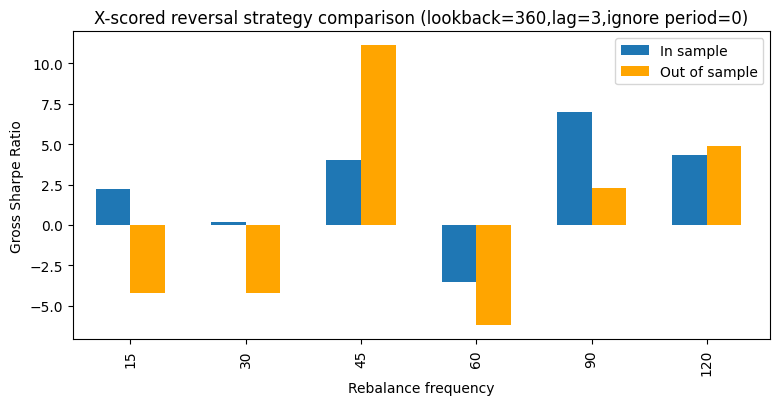

In [96]:
lb=360
lag=3
ip = 0
plt.figure(figsize=(9,4))
plt.title(f'X-scored reversal strategy comparison (lookback={lb},lag={lag},ignore period={ip})')
results_edited.loc[(results_edited['lag']==lag)&(results_edited['lookback window']==lb)&(results_edited['Ignore period']==ip)].set_index('rebalance frequency')['Sharpe Ratio'].plot.bar(position=1,width=0.3)
results_oos.loc[(results_oos['lag']==lag)&(results_oos['lookback window']==lb)&(results_edited['Ignore period']==ip)].set_index('rebalance frequency')['Sharpe Ratio'].plot.bar(position=0,color='orange',width=0.3)
plt.xlim(left=-0.5)
plt.legend(['In sample','Out of sample'])
plt.ylabel('Gross Sharpe Ratio')
plt.xlabel('Rebalance frequency')
plt.show()

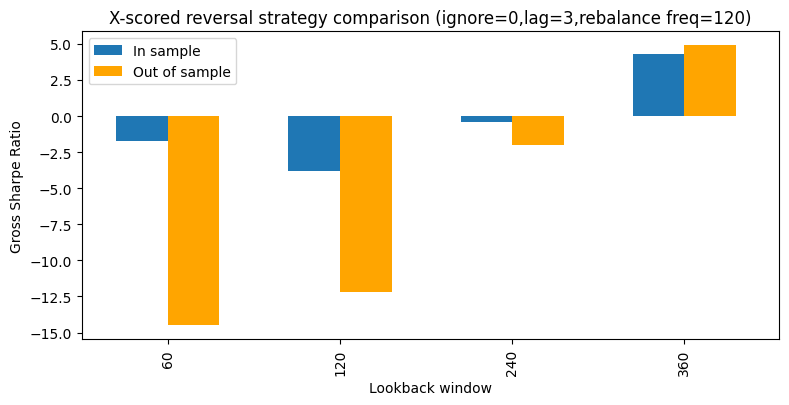

In [106]:
lb=60
lag=3
ip = 0
rf=120
st = 'reversal' if multiplier==-1 else 'momentum'
plt.figure(figsize=(9,4))
plt.title(f'X-scored {st} strategy comparison (ignore={ip},lag={lag},rebalance freq={rf})')
results_edited.loc[(results_edited['lag']==lag)&(results_edited['Ignore period']==ip)&(results_edited['rebalance frequency']==rf)].set_index('lookback window')['Sharpe Ratio'].plot.bar(position=1,width=0.3)
results_oos.loc[(results_oos['lag']==lag)&(results_oos['Ignore period']==ip)&(results_oos['rebalance frequency']==rf)].set_index('lookback window')['Sharpe Ratio'].plot.bar(position=0,color='orange',width=0.3)
plt.xlim(left=-0.5)
plt.legend(['In sample','Out of sample'])
plt.ylabel('Gross Sharpe Ratio')
plt.xlabel('Lookback window')
plt.show()

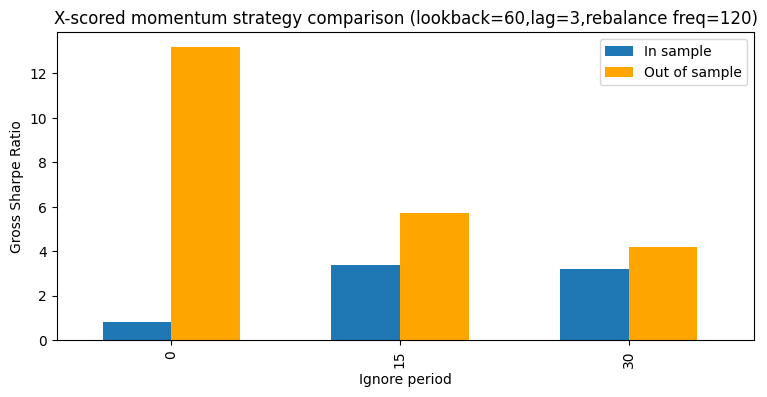

In [76]:
lb=60
lag=3
# ip = 0
rf=120
plt.figure(figsize=(9,4))
plt.title(f'X-scored momentum strategy comparison (lookback={lb},lag={lag},rebalance freq={rf})')
results_edited.loc[(results_edited['lag']==lag)&(results_edited['lookback window']==lb)&(results_edited['rebalance frequency']==rf)].set_index('Ignore period')['Sharpe Ratio'].plot.bar(position=1,width=0.3)
results_oos.loc[(results_oos['lag']==lag)&(results_oos['lookback window']==lb)&(results_oos['rebalance frequency']==rf)].set_index('Ignore period')['Sharpe Ratio'].plot.bar(position=0,color='orange',width=0.3)
plt.xlim(left=-0.5)
plt.legend(['In sample','Out of sample'])
plt.ylabel('Gross Sharpe Ratio')
plt.xlabel('Ignore period')
plt.show()